#Time Series Forecast of Soil Moisture in Münster


## Abstract

Soil moisture forecasting serves as an important component in predicting weather and climate
conditions which then provide valuable information to companies in the agriculture sector as well as
government institutions. By being able to predict soil moisture variables, agricultural companies can
optimize their resources and public institutions can take preventive steps when it comes to floods
and draughts. After gathering data for a wide range of variables through sensors and satellites
predictive models are employed to carry out forecasting. This thesis employs data cleaning and
normalization tools and then introduces the calibrations of Linear Regression, Prophet,
Random Forest, ARIMA and multiple LSTM models with BF10 variables from 30 years to forecast
future BF10 values 30 days ahead. These models were then compared by applying the Root Mean
Squared Error Test and the Convolutional Neural Network proved to provide the most accurate prediction.

## Introduction

Measuring soil moisture and creating forecasts from the data plays a key role in many areas of human life such as predictions for weather and climate, floods and draught monitoring. Many companies and institutions in the private and public sector make use of soil moisture information so that informed decisions can be made regarding how to handle floods, soil erosion, slope failure, manage reservoirs; and it is also used for geotechnical engineering and water quality measures. Soil moisture predictions provide valuable information to increase agricultural productivity, as crop forecasting enables to make better decisions on when to plant and when to harvest in order to maximize crop productivity. To measure water content as a component of crop yield estimation, soil moisture sensors are widely applied. These devices measure the volumetric water content in soil by using for example electrical resistance of the water or its interaction with neutrons. The results help to quantify the need for irrigation so that water waste can also be significantly reduced. Predicting floods significantly contributes to mitigating the impacts of floods on human lives.

When it comes to flood monitoring, soil moisture data is also fed into models which predict how far out the flooding waters could essentially go depending on how wet the soil is before the storm and before the flood begins to make damage. This paper describes the calibration of several supervised regression models – Linear Regression, Prophet, Random Forest, ARIMA and multiple LSTM models – using a dataset of various soil moisture indicator values which were collected during a 30-year-span (from 1991 to 2021) to predict future BF10 values for 30 days ahead. Given that the dataset provides historical data, time series forecasting is applied to predict future values. It is expected that by only focusing on the time component, the models can provide accurate predictions on future BF10 values. The accuracy is measured by applying a baseline model, measure its accuracy with the help of the root mean squared error metric. Then we build the more sophisticated models to see if they perform better on the dataset, use the same metric to measure their performance. At the end of the project we compare the models and choose the one with the best and most reliable performance to make the final prediction.

Our goal is to predict the BF10 value for 30.01.2022. This value is outside of our dataset, so it cannot be compared to actual measurements, however, during the exploratory data analysis phase we will get a good enough impression of our dataset to decide the accuracy of our prediction.  

## Data downloading

In [163]:
!wget https://raw.githubusercontent.com/Szermekm/Capstone/main/munster_hourly.csv

--2022-12-15 23:46:17--  https://raw.githubusercontent.com/Szermekm/Capstone/main/munster_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1756119 (1.7M) [text/plain]
Saving to: ‘munster_hourly.csv.2’

munster_hourly.csv. 100%[===================>]   1.67M  --.-KB/s    in 0.06s   

2022-12-15 23:46:17 (27.2 MB/s) - ‘munster_hourly.csv.2’ saved [1756119/1756119]



## Data preparation

In this section we import the basic data manipulation libraries, pandas and numpy, and load the csv file that contains our data set into a pandas dataframe. 

With the help of the `.head()` function we take our first look at the data. This function shows us the first 5 rows with the corresponding measurements of all the 8 variables. 

In [164]:
import pandas as pd
import numpy as np

df_original = pd.read_csv("munster_hourly.csv", on_bad_lines='skip')

df_original.head()

DATUM  STATIONS_ID  QN_4  TT_TER  RF_TER  VGSL  TS05  BF10
0  1991-01-01 07:00:00         1766    10     3.0    91.0   0.3   2.9   102
1  1991-01-01 14:00:00         1766    10     4.8    85.0   0.3   2.9   102
2  1991-01-01 21:00:00         1766    10     3.9    82.0   0.3   2.9   102
3  1991-01-02 07:00:00         1766    10     5.6    94.0   1.4   6.3   110
4  1991-01-02 14:00:00         1766    10    11.0    87.0   1.4   6.3   110

In [165]:
df_original.tail()

DATUM  STATIONS_ID  QN_4  TT_TER  RF_TER  VGSL  TS05  \
35667  2021-12-30 00:00:00         1766     1    11.6    90.0   0.8   9.4   
35668  2021-12-30 06:00:00         1766     1    11.1    98.0   0.8   9.4   
35669  2021-12-30 12:00:00         1766     1    14.3    83.0   0.8   9.4   
35670  2021-12-30 18:00:00         1766     1    13.5    90.0   0.8   9.4   
35671  2021-12-31 00:00:00         1766     1    13.8    83.0   0.8  10.5   

       BF10  
35667   104  
35668   104  
35669   104  
35670   104  
35671   101

### Columns of the dataset:

**DATUM**: The datetime column

**STATIONS_ID**	DWD weather station ID
  * 1766 = Münster/Osnabrück

**QN_4**: quality level of TT_TER and RF_TER columns
  * 1- only formal control during decoding and import
  * 2- controlled with individually defined criteria
  * 3- ROUTINE control with QUALIMET and QCSY
  * 5- historic, subjective procedures
  * 7- ROUTINE control, not yet corrected
  * 8- quality control outside ROUTINE
  * 9- ROUTINE control, not all parameters corrected
  * 10- ROUTINE control finished, respective corrections finished

**TT_TER**: air temperature

**RF_TER**: relative humidty

**VGSL**: real evapotranspiration over gras and sandy loam (mm)

**TS05**: mean daily soil temperature in 5 cm depth for uncovered typical soil (°C)

**BF10**: soil moisture under
grass and sandy loam
between 0 and 10 cm
depth in % plant useable
water (%nFK)

## Exploratory Data Analysis

In the exploratory data analysis section we will use different types of methods and graphs to better understand the data we are working with. But before we start the data visualization and interpretation it is worth mentioning what key aspects of the data we are looking to analyze.

According to Lazzeri (2021), in time series analysis there are four key aspects of the dataset that must be observed before preparing the data for modelling:


1.   Long-term movements
2.   Seasonal variations
3.   Cyclic variations
4.   Random fluctuations

Long-term movements show us the lasting increases or decreases through the protracted period. It is very common for time series data to have a clear trend, take for instance the rising sea levels or global population growth. However, trend is something that most machine learning models can't handle very well, so the data should be made stationary. In our case, we will see that our data set has a decreasing trend. This is both intuitively plausible, as rising air temperatures, decreasing precipitation and longer droughts will naturally lead to less soil moisture, but our visualizations and calculations also underscore this observation. 

Seasonal variations are fluctuations in our data recurring in fixed intervals. These fluctuations can be societal (holidays) or natural (climate). Our data set has a strong seasonal component, as expected, it shows that the soil moisture is much higher in the winter months than in the summer. Low temperature is important for the water holding capacity of the soil. This seasonal component must be taken into account when we create our predictions in regards to the target variable.

Cyclic variations, contrary to seasonal variations, don't have a fixed period and a predetermined length, but they are usually longer than a year. A good example for this is the business cycle that most organization go through: prosperity, recession, depression and recovery. The performance numbers of a company are highly dependent on its present phase. The cyclic variations are not influential in our case, we can say that we are in the global warming phase of our climate cycle, but this is true for the whole period of our investigation. 

Random or irregular variations are unforeseen and unpredictable events. These events can distort the data set and create outliers, thus damaging the predictive power of the machine learning models. These variations can be earthquakes, volcano eruptions or strikes. Fortunately, our series is not effected by random variations.




With the help of the `describe()` method we can check the mathematical dimensions of our dataset and make some important explorations:


*   There are no missing values in our dataset
*   Our target variable has some values equal to zero, but we will see later that these values are consistent with the movement of the series, so they are not measurement errors 
*   25% percent of the target variable is over 100%, we have to check the measurement method to decide if this is a mistake
*   The station ID is a constant that has zero influence on our prediction so it can be deleted



In [166]:
df_original.describe()

STATIONS_ID          QN_4        TT_TER        RF_TER          VGSL  \
count      35672.0  35672.000000  35672.000000  35672.000000  35672.000000   
mean        1766.0      8.641540     10.755136     76.796675      1.236676   
std            0.0      2.772131      7.591943     18.688003      0.978120   
min         1766.0      1.000000    -21.300000   -999.000000      0.000000   
25%         1766.0     10.000000      5.200000     65.000000      0.500000   
50%         1766.0     10.000000     10.600000     81.000000      1.000000   
75%         1766.0     10.000000     16.100000     91.000000      1.800000   
max         1766.0     10.000000     37.700000    100.000000      6.300000   

               TS05          BF10  
count  35672.000000  35672.000000  
mean      11.096577     70.367739  
std        7.684733     37.325784  
min       -8.000000      0.000000  
25%        4.600000     40.000000  
50%       10.900000     87.000000  
75%       17.500000    102.000000  
max       29.200000    111.000000

In [167]:
df_original.shape

(35672, 8)

### Data types

Generally, all machine learning methods use tensors as their basic data structure. Tensors are containers for data, and machine learning algorithms work best when they contain numerical data. Tensors have three key attributes: the number of axes, the shape and the data type.

The number of axes defines the type of the tensor: rank-1 tensor (vector), rank-2 tensor (matrix) and higher rank tensor (depends on the number of matrices in the arrays). Time series data for example is usually represented by a rank-3 tensor, where the inputs are: batch size, timesteps and dimensionality.

The shape is defined by the tensor’s dimensions along each axis. 

The data type shows the format in which the variable stores its information. With the help of the `info()` function, we can see that most of our data has a numerical dtype, apart from the values in the “Datum” column, those are objects. When checking the data types of a dataframe, it is wise to look for columns that have strings as dtype. This can mean that those columns contain categorical values, and these values have to be handled differently to the numerical ones. As machine learning algorithms can not handle categorical data, it has to be transformed to a measurable format. For example, if our target variable, BF10 would be a description instead of a concrete number, like the soil moisture is high/low, we would have to adopt a scale in which high is equal to 5 and low is equal to 1 and replace the strings with these integer values. However, as we have determined, we have numerical data and a datetime object, so we don’t have to make any dtype transformations right now.


In [168]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATUM        35672 non-null  object 
 1   STATIONS_ID  35672 non-null  int64  
 2   QN_4         35672 non-null  int64  
 3   TT_TER       35672 non-null  float64
 4   RF_TER       35672 non-null  float64
 5   VGSL         35672 non-null  float64
 6   TS05         35672 non-null  float64
 7   BF10         35672 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 2.2+ MB


With the help of the `isnull()` method we can determine that the dataset does not have any missing values.  As missing values can easily distort the results of machine learning models, this is a very welcomed discovery. If we found missing values we would have to perform an imputation technique to keep the robustness of our data. These techniques include mean imputation, hot deck imputation and interpolation. Another option is simply dropping the missing values if they don't occur very often in the dataset.

In [169]:
df_original.isnull().sum()

DATUM          0
STATIONS_ID    0
QN_4           0
TT_TER         0
RF_TER         0
VGSL           0
TS05           0
BF10           0
dtype: int64

In [170]:
# creating a new dataframe to prepare for the reindexing plus changing the data type of the DATUM column
reindexed_df = df_original.copy()
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df.head()

DATUM  STATIONS_ID  QN_4  TT_TER  RF_TER  VGSL  TS05  BF10
0 1991-01-01 07:00:00         1766    10     3.0    91.0   0.3   2.9   102
1 1991-01-01 14:00:00         1766    10     4.8    85.0   0.3   2.9   102
2 1991-01-01 21:00:00         1766    10     3.9    82.0   0.3   2.9   102
3 1991-01-02 07:00:00         1766    10     5.6    94.0   1.4   6.3   110
4 1991-01-02 14:00:00         1766    10    11.0    87.0   1.4   6.3   110

In [171]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

We plot our data to have an overview of the complete signal before we start the data manipulation. We will delve deeper into the data in the visualization section, but even on this basic plot two important aspects can be noticed: the signal has a strong seasonal component and it does not seem to have outliers, which means we don't have to perform outlier cleaning before the modelling phase.

Text(0, 0.5, 'BF10 [%nFK]')

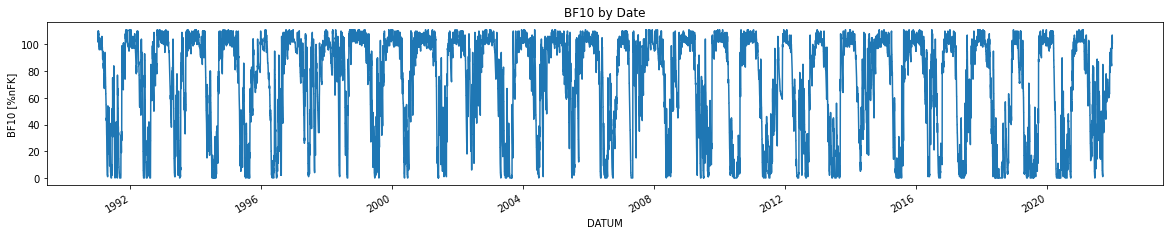

In [172]:
plt.plot(reindexed_df.DATUM, reindexed_df.BF10)
 
plt.title('BF10 by Date')
 
plt.xticks(rotation=30, ha='right')
 
plt.xlabel('DATUM')
plt.ylabel('BF10 [%nFK]')

In [173]:
display(pd.to_datetime(df_original['DATUM'], format='%Y-%m').head())


assert (reindexed_df.DATUM == pd.to_datetime(df_original['DATUM'], format='%Y-%m')).all()

0   1991-01-01 07:00:00
1   1991-01-01 14:00:00
2   1991-01-01 21:00:00
3   1991-01-02 07:00:00
4   1991-01-02 14:00:00
Name: DATUM, dtype: datetime64[ns]

### Reindexing

We set the DATUM column as index and change its data type to 'datetime64'

In [174]:
reindexed_df.set_index("DATUM", inplace=True)
#reindexed_df.index.name = "Date"
reindexed_df.index = reindexed_df.index.astype('datetime64[ns]')
#reindexed_df.drop(["STATIONS_ID",	"QN_4", "TT_TER",	"RF_TER",	"VGSL",	"TS05"], axis = 1, inplace=True)

### Creating univariate series

Here we use the `drop()` function to create the univariate data set.

In [175]:
uni_df = reindexed_df.drop(["STATIONS_ID",	"QN_4", "TT_TER",	"RF_TER",	"VGSL",	"TS05"], axis = 1)

In [176]:
uni_df.head()

BF10
DATUM                    
1991-01-01 07:00:00   102
1991-01-01 14:00:00   102
1991-01-01 21:00:00   102
1991-01-02 07:00:00   110
1991-01-02 14:00:00   110

### Resampling

Currently our target variable, BF10, is being measured three times a day. However, our task is to predict a daily measurement, so it is logical to change the frequency of the variable. Resampling is advantageous also because some of the varibales are measured with a different frequency (five times a day instead of three), and it will make the data visualization and preparation simpler  as well. We perform a resampling technique with the help of the `resample()` method. There are two types of resampling, upsampling, when the frequency of the sample is increased, and downsampling, when it is decreased. We perform downsampling, and we take the mean of the three daily datapoints.

In [177]:
uni_df = uni_df.resample("D").mean()

In [178]:
uni_df.head()

BF10
DATUM            
1991-01-01  102.0
1991-01-02  110.0
1991-01-03  110.0
1991-01-04  106.0
1991-01-05  109.0

With the help of the `describe()` method we make sure that the downsampling did not cause data loss.



In [179]:
uni_df.describe()

BF10
count  11323.000000
mean      71.004063
std       37.056605
min        0.000000
25%       41.000000
50%       88.000000
75%      102.000000
max      111.000000

### Visualization

Data visualization is the graphical representation of information and data. By creating visual elements like charts, graphs, and maps with the help of data visualization tools is it possible to better see and understand trends, outliers and patterns in data. It also provides a great way for experts to present data to non-technical audiences, so that misunderstandings can be avoided and the interpretation of the data is faster and much more effective.

Sequential data is especially well presentable with visualization tools, and in this section we will use different charts and plots to have a better general understanding of our data while also inspecting different groupings of the time variables to learn about the specialties of our series.

First we randomly pick a year from the series to get familiar with the yearly fluctuations of the data

In [180]:
display(uni_df.loc["1995"])

BF10
DATUM            
1995-01-01  108.0
1995-01-02  105.0
1995-01-03  102.0
1995-01-04  102.0
1995-01-05  102.0
...           ...
1995-12-27  102.0
1995-12-28  102.0
1995-12-29  102.0
1995-12-30  101.0
1995-12-31  101.0

[365 rows x 1 columns]

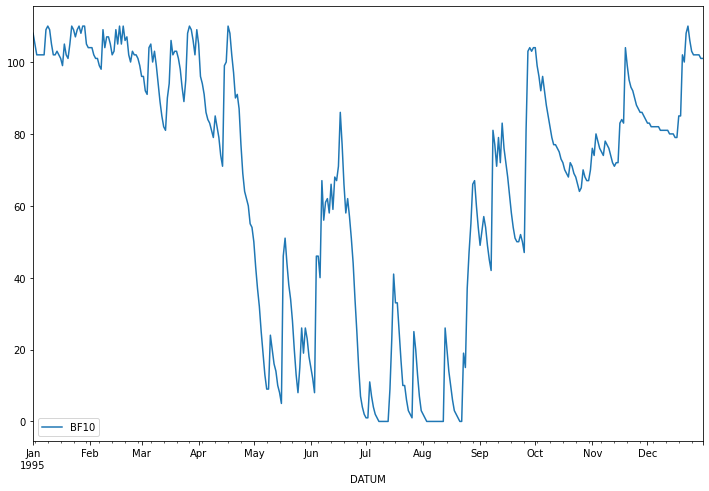

In [181]:
uni_df['1995-01':'1995-12'].plot(figsize=(12,8))

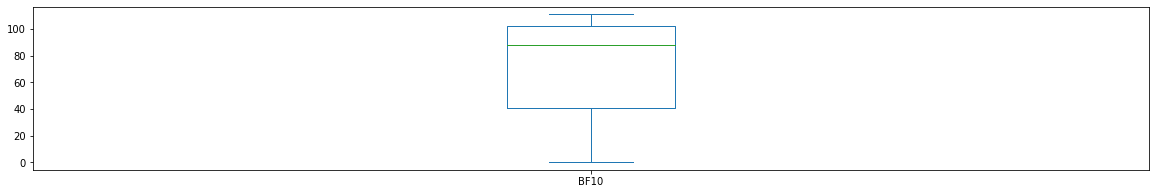

In [182]:
uni_df.plot.box() # we check the general distribution of the BF10 variable

In [183]:
import plotly.express as px
figure = px.line(uni_df, x = uni_df.index, 
                 y = "BF10", 
                 title = "Time Series Analysis (Line Plot)")
figure.show()

With the help of the rangeslider tool we can easily inspect any section of our dataset. The trendline is also visible on this plot and we can see a clear decreasing trend.

In [184]:
fig = px.scatter(uni_df, x=uni_df.index, y="BF10", trendline="ols")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [185]:
fig = px.line(uni_df, x=uni_df.index, y='BF10', title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

The best way to visualize the seasonality of our data set is to outline the distribution of monthly variables separately using a boxplot. This way we can see very clearly the huge differences between the measurements of the seasons. Especially the difference between the summer and the winter values is very apparent, where the highest value in the summer is around 20% smaller than the lowest value in winter. 

The other very visible property of this visualization is the difference in the variance of the measurements. In the winter month, the variance is very low, the BF10 values fluctuate mostly between 100 and 120, however, in the summer month the variance is very significant, around 50 units, more than double compared to the winter month. This attribute in our data can have a positive projection to our forecast as we will predict a winter value.





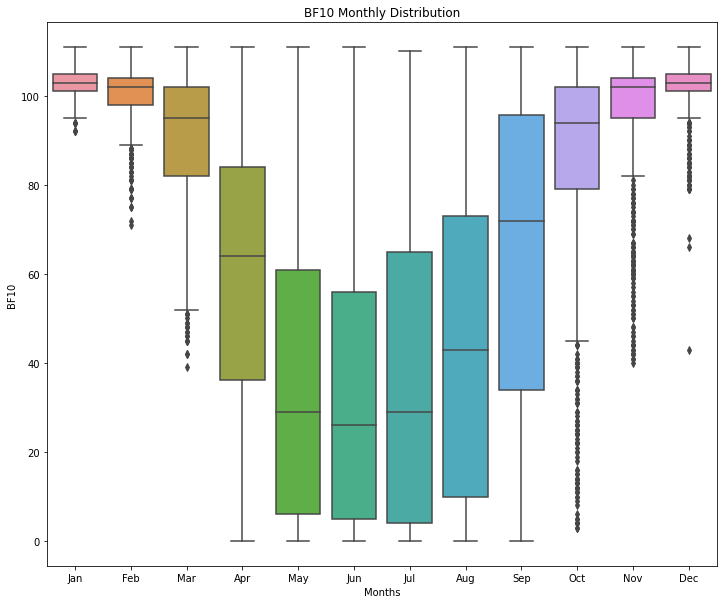

In [186]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,10))

sns.boxplot(uni_df.index.strftime("%b"), uni_df["BF10"], ax=ax)

plt.title("BF10 Monthly Distribution")
plt.xlabel("Months")
plt.show()

We continue our investigation with another boxplot, but this time we will check the yearly distributions. In this visualization we expect to have a good overview of the studied period and see the trends in our data set.

The first thing we can notice on the chart is the significant difference between the yearly measurements. These yearly changes were not evident on the previous visualizations where this attribute has been overshadowed by the strong seasonality component of the time series.

We can also observe an inconsistent but decreasing trend in the averages from the year with the highest mean, 2000. The distribution of the measurements are also quite erratic, but it can be said that in the last third of the time series the variance within a year is significantly higher and it is more likely to come across extremely low values for BF10.

The dots under the boxes in the visualization could be outliers and has to be examined. However, as we investigate further by checking the year with the lowest variance and the most dots (1998) in the next chart, we can see that the low measurements are consistent with previous trends as they were observed in the summer months.

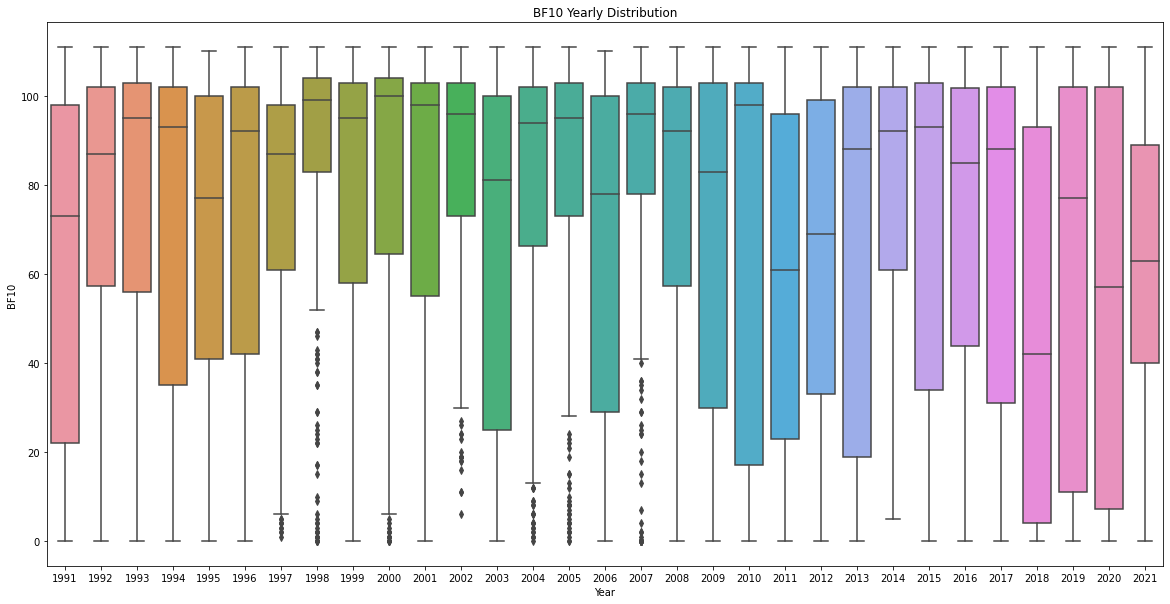

In [187]:
fig, ax = plt.subplots(figsize=(20,10))

sns.boxplot(uni_df.index.year, uni_df["BF10"], ax=ax)

plt.title("BF10 Yearly Distribution")
plt.xlabel("Year")
plt.show()

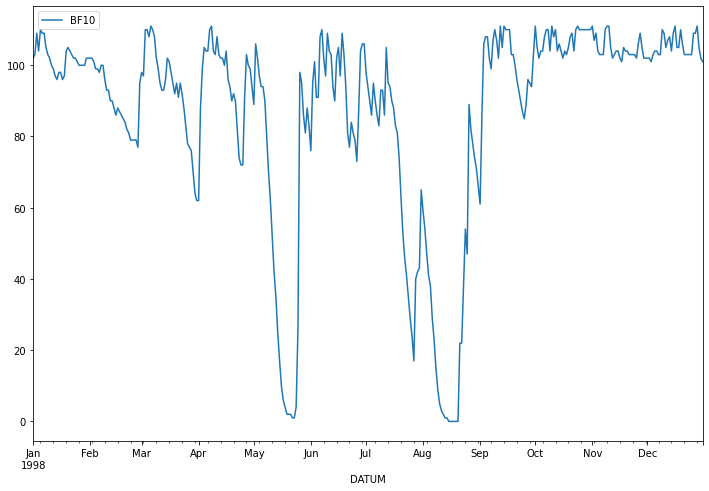

In [188]:
uni_df['1998-01':'1998-12'].plot(figsize=(12,8))

### Autocorrelation

Autocorrelation measures the correlation between the observation at the current time spot and the observations at previous time spots in the same time series.

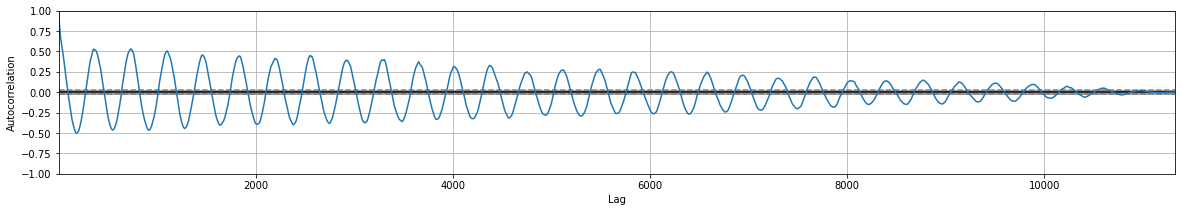

In [189]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
autocorrelation_plot(uni_df['BF10'].tolist())

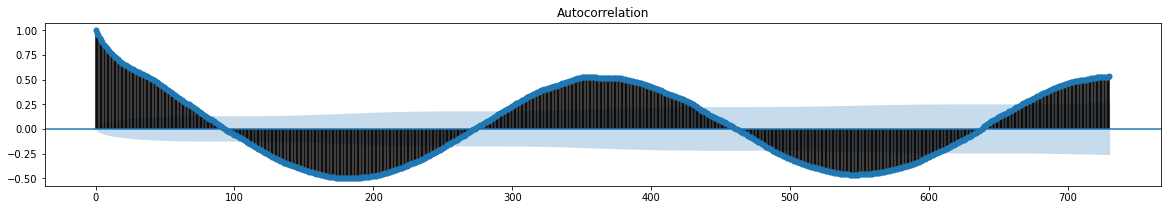

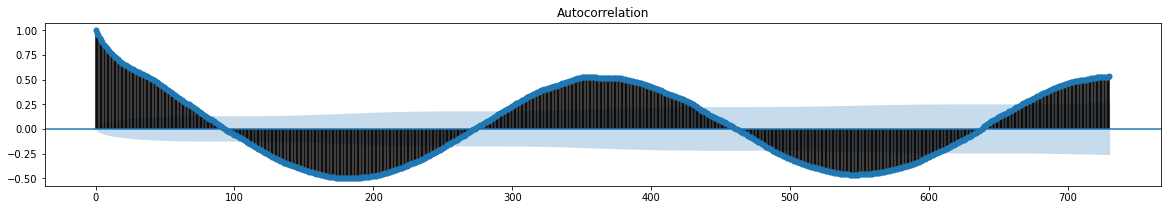

In [190]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
plot_acf(uni_df['BF10'].tolist(), lags=730)

Autocorrelation shows how similar is the signal to the shifted version. We can see a peek in every 365*n point, the peeks are almost the same high. This means that every year shows strong similarities to each other


### Partial Autocorrelation

The partial autocorrelation function (PACF) evaluates directly how
a measurement is correlated with another measurement n time steps
apart.

According to Lewis (2016): "A partial autocorrelation is the amount of correlation between
an observation xt and a lag of itself (say xt−k) that is not
explained by correlations of the observations in between."

The partial autocorrelation function can be imported from the statsmodels library and it is neeed for us to determine the ARIMA model's p parameter. As we have 2 spikes on the plot we will pick 2 as the p value in the ARIMA model.

We will use a lag of 370 because we have previously determined with the autocorrelation plot that our data has a 365 day periodicity and we want to include that completely.

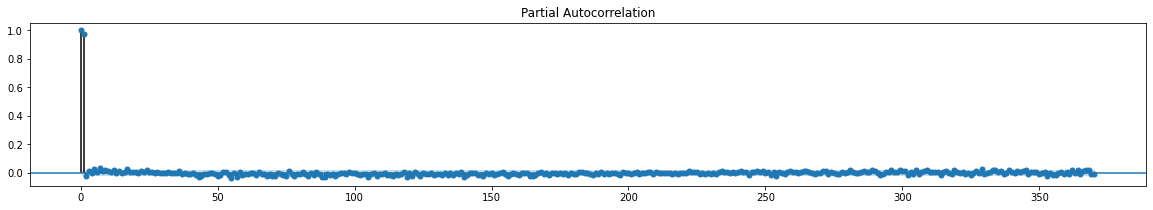

In [191]:
#import plot_pacf() function
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

# plot the pacf function on the ts_data_load_subset

plot_pacf(uni_df, lags=370)
pyplot.show()

### Decomposition

Time series decomposition refers to the method by which we reduce our time series data into its following four components:



1.   Trend [T]
2.   Cycle [C]
3.   Seasonality [S]
4.   Residual [R]

Statsmodel's seasonal_decompose function has two types of decomposition methods: additive and multiplicative. 
The additive decomposition takes the sum of its components:

${\displaystyle Y=T+S+R}$

The multiplicative decomposition assumes that the time series data is the  multiplication of the trend with the seasonality and the residual:

${\displaystyle Y=T*S*R}$

The way to decide between the two methods is to check the variation of the seasonal component. If it grows over time, then the series is multiplicative. However, as we will see on the autocorrelation plot, in our case the seasonal component is constant, so we will use the additive seasonal decomposition method.





In [192]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

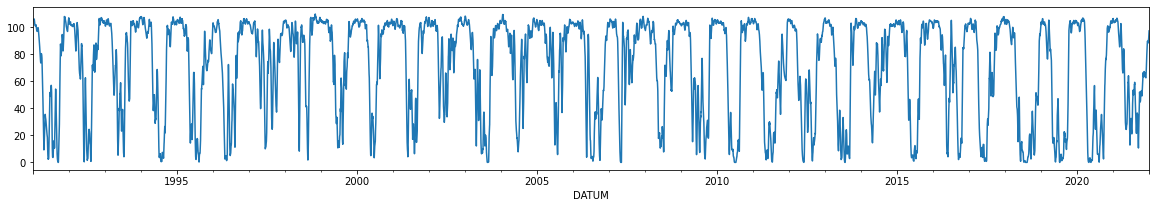

In [193]:
uni_df["BF10"].rolling(window=12, center=False).mean().plot()

We chose additive signal-decomposition because we have zero and negative values so can't use multiplicative decomposition. The additive decomposition decomposes the signal to a seasonal and a trend component and shows residual errors. We 365 periodicity because of the strong seasonal component that has a recurring amplitude of 70 every year.

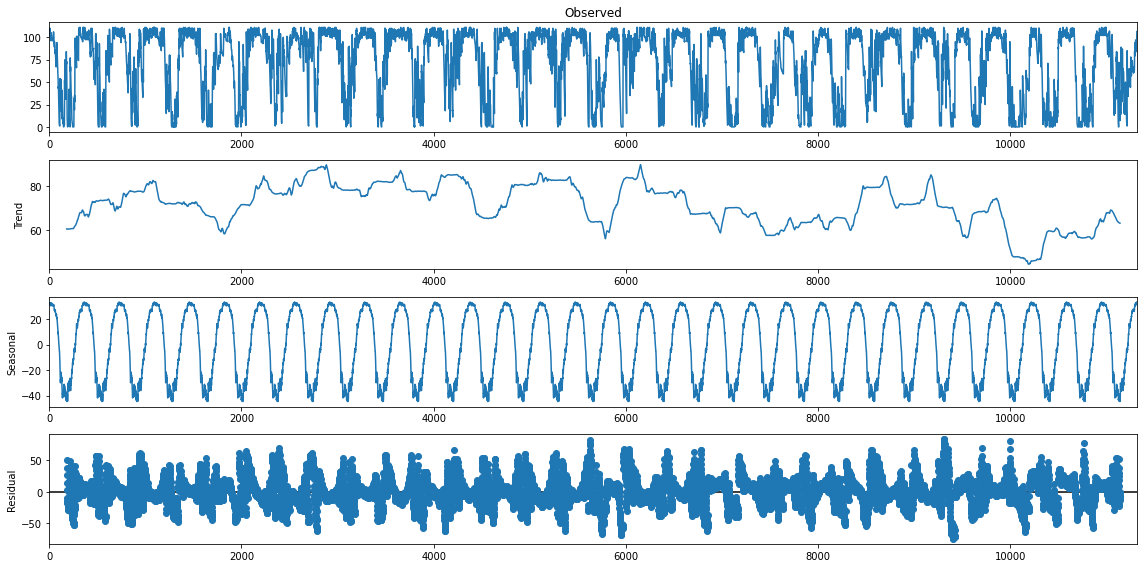

In [194]:
import matplotlib as mpl
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8))
    
    # window size is 365 based on autocorrelation
    analysis = seasonal_decompose(uni_df["BF10"].values,model="additive", period=365) 

    analysis.plot()
    plt.show()

In [195]:
#Determine rolling statistics
rolmean = uni_df['BF10'].rolling(window=365).mean() #window size 365 denotes 365 days, giving rolling mean at yearly level
rolstd = uni_df['BF10'].rolling(window=365).std()

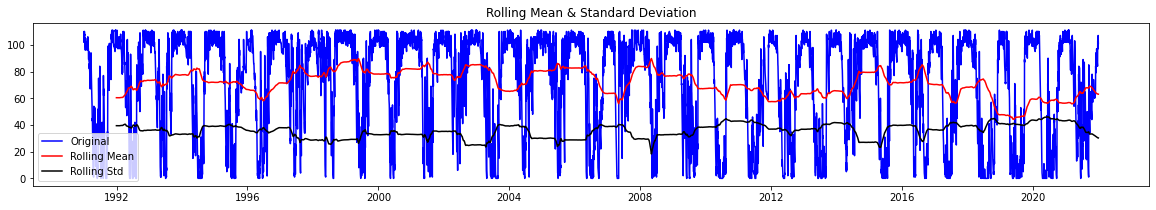

In [196]:
#Plot rolling statistics
orig = plt.plot(uni_df['BF10'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Mean and std varies by a small margin over the time. This means we will try to differencing the signal.

### Augmented Dickey-Fuller test I.

In order to be able to determine whether the provided dataset is stationary or not, the Augmented Dickey Fuller test was employed in this project. The original Dickey Fuller test assumes that the inspected time series is autoregressive process meaning that the time series is a linear function of itself which is lagged one time period in the past. The stationarity of the times series depends on whether the time series has a unit root or not. The reason behind the significance of getting information about stationarity is that it defines which models can and cannot be used for a certain dataset. Stationarity basically assumes that the mean and the standard deviations are constant and that there is no seasonality in the dataset. In case any of these assumptions or requirements of stationarity is violated, the time series does not characterize as stationary. To extend the Dickey Fuller test to a more complex time series model than autoregressive 1 models, Augmented Dickey Fuller test is employed, where the assumption is that the time series is an AR model. In other words, the Augmented Dickey Fuller test is accommodating more complex models which have unknowns orders. The hypotheses of the time series having or not having a unit root is the same as in the basic Dickey Fuller test.

In [197]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [198]:
ad_test(uni_df['BF10'])

1. ADF :  -9.321864497522434
2. P-Value :  9.843300294907587e-16
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 11306
5. Critical Values :
	 1% :  -3.4309285233787197
	 5% :  -2.8617956761723566
	 10% :  -2.566906091318959


The dataset passes the Augmented Dickey Fuller test, but the mean is not constant, which means that the series is non-stationary.

### Differencing

In this section we will use differencing methods to try to make the series stationary. First we push the signal by 1 day, and the we divide from the original signal the pushed signal. We create the ts_diff dataset for experimenting.

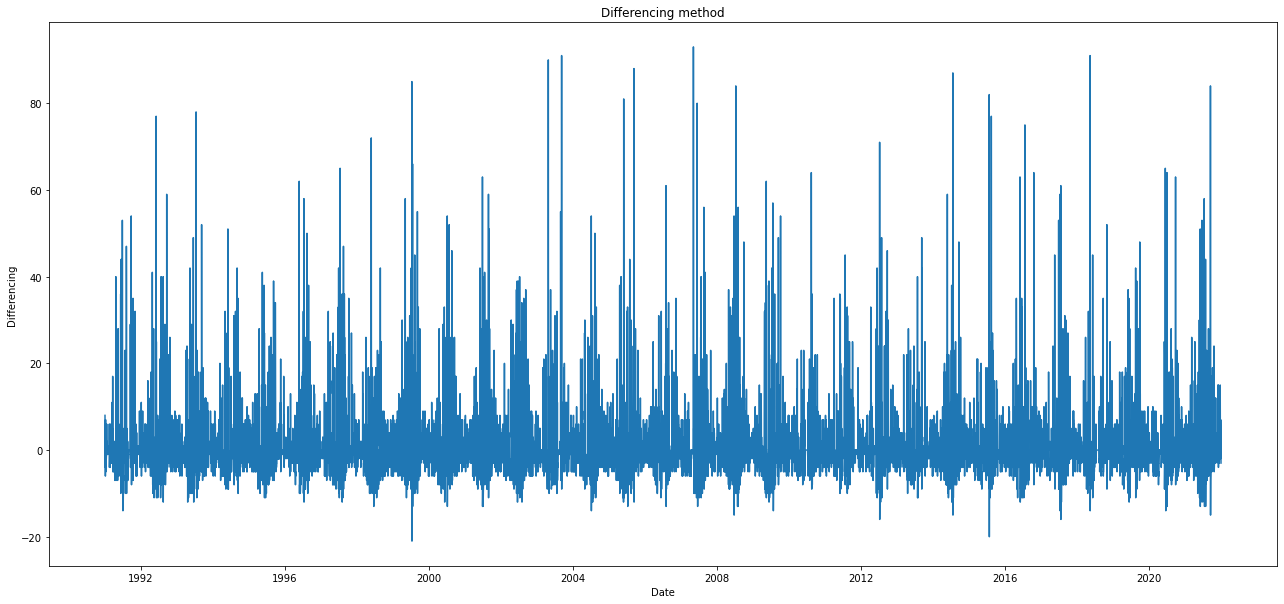

In [199]:
# differencing method
ts_diff = uni_df['BF10'] - uni_df['BF10'].shift(1) # we push the signal by 1 day 
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing")
plt.show()

In [200]:
ts_diff.dropna(inplace=True) # due to shifting there are nan values

In [201]:
#Determine rolling statistics
rolmean = ts_diff.rolling(window=365).mean() #window size 365 denotes 365 days, giving rolling mean at yearly level
rolstd = ts_diff.rolling(window=365).std()

After differencing the mean and the standard deviation became almost constant. This shows that the "d" value in the ARIMA model will equal to 1.

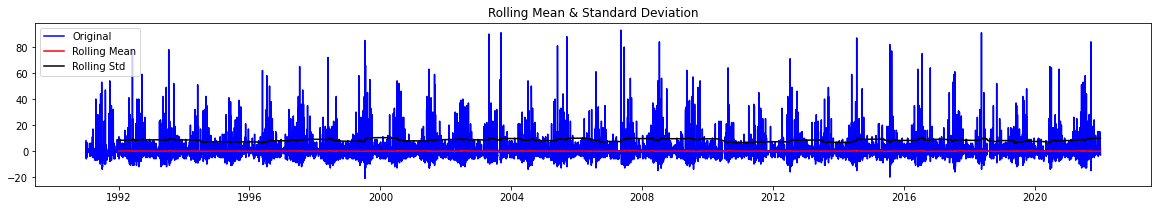

In [202]:
#Plot rolling statistics
orig = plt.plot(ts_diff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [203]:
ts_diff.head()

DATUM
1991-01-02    8.0
1991-01-03    0.0
1991-01-04   -4.0
1991-01-05    3.0
1991-01-06   -6.0
Freq: D, Name: BF10, dtype: float64

### Augmented Dickey-Fuller test II.

In our second Augmented Dickey-Fuller test on the differenced dataframe we can conclude with greater confidence than in the previous ADF test that our series is stationary. 

In [204]:
ad_test(ts_diff)

1. ADF :  -27.32261113194259
2. P-Value :  0.0
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression: 11299
5. Critical Values :
	 1% :  -3.430928881869226
	 5% :  -2.8617958345904113
	 10% :  -2.5669061756444


## Machine Learning models

In [205]:
uni_df['month'] = uni_df.index.month
uni_df['day'] = uni_df.index.day
uni_df['year'] = uni_df.index.year

### Cross Validation

Instead of the usual train-test split we will use Scikit-Learn's K-fold cross-validation feature. This function randomly splits the training set into K number of folds, then it trains and evaluates the model K times, iterating through the folds, then it gives the mean and the standard deviation of the K number of results. With the help of the standard deviation we can have a clue about how precise the estimate is, something that is missing from the regular cross-validation splits. The K-folds cross-validation can give us more precise results, however, this comes with greater runtime for the models, depending on the number of folds. (Géron, 2019)

Bearing this in mind, we chose to have 5 folds, as this split can give us good results without huge runtime. We will use this split for all of our models, so they will be evaluated on the same basis and their results will be directly comparable.

In [206]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=30,
    test_size=365*3,
)

### Baseline Model

Baseline models are needed to measure the performance of other models and to decide whether it is even justified to deploy more resource-hungry solutions. The most straightforward approach would be to assume that the BF10 measurement is going to be the same 30 days from now as it is today. However, this method would completely ignore the fact that our data show strong seasonality, so the value can change dramatically in a month. We must take this aspect into consideration when we choose the baseline model.

The best and most convenient way to reach our goal is to write an algorithm that predicts the BF10 variable based on last year's measurement. We simply shift the signal by 365 days using the `shift()` method, and create the new variable, BF10_hat, which is our predicted value. For example, we predict the 01.01.2021 BF10 value based on the 01.01.2020 measurement. We use the 365 days because we have determined during the exploratory data analysis that the signal has a yearly seasonality.
 
After that we will calculate the Root Mean Squeared Error(RMSE) to evaluate our approach and to have a metric that we can later compare to the other models. We chose RMSE because it is generally a good performance measure for regression problems. It shows how much error the model makes in its predictions, with a higher weight for large errors. This metric is advantageous also because its result is in the same unit as the target variable, which helps to understand the error rate more intuitively.

This baseline model will take into account the seasonality of our data, because it will only work with the same dates. However, as we have uncovered in the data exploration section, our data has a decreasing trend that will be underrepresented by this simple model. This could be an aspect where the more sophisticated methods can get the upper hand.

In [207]:
baseline_df = uni_df.copy()
baseline_df['BF10_hat'] = baseline_df['BF10'].shift(365) #shifting the dataset by one year
baseline_df = baseline_df = baseline_df.dropna() #deleting the NAN values created by the shifting in the BF10_hat column
baseline_df.head()

BF10  month  day  year  BF10_hat
DATUM                                        
1992-01-01  101.0      1    1  1992     102.0
1992-01-02  100.0      1    2  1992     110.0
1992-01-03   98.0      1    3  1992     110.0
1992-01-04  100.0      1    4  1992     106.0
1992-01-05  111.0      1    5  1992     109.0

In [208]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from math import sqrt

X_orig = baseline_df
y_orig = baseline_df

cvscores = []
i = 1

# iterating through the cross validation list
for train, test in list(ts_cv.split(X_orig, y_orig)):
    print(i) # <- FOLD number
    yhat = X_orig.iloc[test].BF10.values
    y = X_orig.iloc[test].BF10_hat.values
    
    # adding the error metric
    rmse = sqrt(mean_squared_error(y, yhat))
    print(rmse)
    cvscores.append(rmse)
    
    i+=1 # moving to the next FOLD

1
42.26193598117238
2
31.68188050781417
3
36.20203329388934
4
45.02896074679131
5
30.423509895110715


In [209]:
print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))

37.12 (+/- 5.73)


The Baseline Model's Root Mean Squared Error is 37.12 with a relatively high standard deviation of 5.73. This error seems to be quite high, but as the Random walk process states, the further in the future we are trying to predict, the higher the uncertainty of our prediction is. 

Now that we have our baseline error we can start forecasting on more delicate models and gather their error metrics for the final comparison.

### Linear Regression

Following the baseline model, linear regression model is calibrated with the available
BF10 variable values. The reason for applying a linear regression model to the
prediction problem is that this model type includes simple formulas to carry out
predictive analysis. The model predicts an output based on a new input and previous
learning. This allows us to discover whether there is a relationship between an
independent variable and a dependent variable, which is the target. For instance, in a
Simple Linear Regression we want to know if there’s a relationship between x and y.
This is very useful when it comes to forecasting to see for example where the trend is
going. In this case a regression model using one independent and one dependent
variable is described.

The values in the month and day columns are coming from a limited set and we define them as categorical values. 

In [210]:
categorical_columns = [
    "month",
    "day",
]

In [211]:
X = uni_df.drop(['BF10'], axis = 1)
y = uni_df.BF10

all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

The all_splits dataframe contains the cross validation data. This table has a length of 5, ad every element contains a list of 2. The elements of train_0 are indeces and they can be encoded later.

In [212]:
X.iloc[test_0]

month  day  year
DATUM                       
2007-01-05      1    5  2007
2007-01-06      1    6  2007
2007-01-07      1    7  2007
2007-01-08      1    8  2007
2007-01-09      1    9  2007
...           ...  ...   ...
2009-12-30     12   30  2009
2009-12-31     12   31  2009
2010-01-01      1    1  2010
2010-01-02      1    2  2010
2010-01-03      1    3  2010

[1095 rows x 3 columns]

In [213]:
y.iloc[test_0]

DATUM
2007-01-05    103.0
2007-01-06    110.0
2007-01-07    110.0
2007-01-08    108.0
2007-01-09    104.0
              ...  
2009-12-30    111.0
2009-12-31    109.0
2010-01-01    104.0
2010-01-02    108.0
2010-01-03    106.0
Freq: D, Name: BF10, Length: 1095, dtype: float64

In [214]:
from sklearn.model_selection import cross_validate

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

One hot encoding

One-hot Encoding is a feature encoding strategy to convert categorical features into a numerical vector. For each feature value, the one-hot transformation creates a new feature demarcating the presence or absence of feature value. One-hot encoding creates d-dimensional vectors for each instance where d is the unique number of feature values in the dataset.

In our case we encode the months from 1 to 12. After using the One-hot encoder we will get 12 column for the months, where the first will be named month_1 and last is month_12. The column which contains the current record will have 1 as a value, the others will have 0.

After that we use the Min-max-scaler to normalize the BF10 values to a range between 0-1 for the modelling phase, then we will rescale them for the evaluation.

In [215]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     19.853 +/- 1.826
Root Mean Squared Error: 26.938 +/- 2.707


From the 5 fold cross-validation we take the first train and test sets. We run the model on the train set and evaluate it on the test.

In [216]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

The test contains 3*365 days but we only take the last 365 now.

In [217]:
last_year = slice(-365, None)
X.iloc[test_0].values[last_year]

array([[   1,    4, 2009],
       [   1,    5, 2009],
       [   1,    6, 2009],
       ...,
       [   1,    1, 2010],
       [   1,    2, 2010],
       [   1,    3, 2010]])

We plot the original and the predicted values for the last 365 days

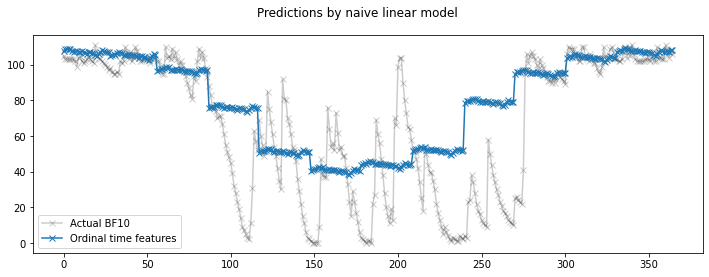

In [218]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by naive linear model")
ax.plot(
    y.iloc[test_0].values[last_year],
    "x-",
    alpha=0.2,
    label="Actual BF10",
    color="black",
)
ax.plot(naive_linear_predictions[last_year], "x-", label="Ordinal time features")
_ = ax.legend()

The result of the Linear Regression is surprisingly good compared not only to the baseline but also to the deep learning models. In the exploratory data analysis section we noticed that the winter months have a lower fluctuation then the summer months, and based on the visualization above it is clear that this model worked much better with the lower variance periods. As expected, the regression line is very angular, that comes from the sharp monthly changes. The prediction also underscores another previous assumption, namely that the "b" variable (month) has a bigger role in the algorithm than the "c" (day) variable. This is of course intuitively also very easily understandable, from weather perspective it is more important which month we are examining than which precise day of a random month.

### Prophet

Prophet is a relatively new model developed by Facebook as a response to some problems with forecasting which are namely the phenomena according to which many applications require forecast, or often just a single metric has to be forecast several times, or forecasting training is not so widespread or that there are not a lot of direct tools or solutions existing for forecasting. One of the main goals with developing Prophet was to enhance the forecasting possibilities for users, and the way this was achieved it is that a semi-automation was introduced within this model. So basically the model is built in a way that it considers similarities across forecasting problems and then it is capable of solving most of them. Regarding its structure, Prophet is basically an abstraction layer over the data that had previously been standardized and this standardized data is wrapped like an object so it is capable of providing explanations, predictions and also diagnostics on the modelling itself.

In [139]:
#!pip install prophet==1.1.1

In [140]:
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

m = Prophet(daily_seasonality=True)
prophet_df = uni_df.copy()
prophet_df = prophet_df.reset_index()

prophet_df = prophet_df.rename(columns={"DATUM": "ds", "BF10": "y"})
m.fit(prophet_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpy43jv43z/mvziytec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy43jv43z/_f42mzel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59328', 'data', 'file=/tmp/tmpy43jv43z/mvziytec.json', 'init=/tmp/tmpy43jv43z/_f42mzel.json', 'output', 'file=/tmp/tmpy43jv43z/prophet_model0bb6bqi8/prophet_model-20221215214112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [141]:
future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds       yhat  yhat_lower  yhat_upper
11683 2022-12-27  85.475827   57.295477  115.813060
11684 2022-12-28  85.649499   54.137003  116.915902
11685 2022-12-29  85.627655   54.716416  116.522859
11686 2022-12-30  85.193998   56.882909  116.257909
11687 2022-12-31  85.116480   54.591278  116.455467

We use in Prophet's built in plotting mechanism to visualize the results.

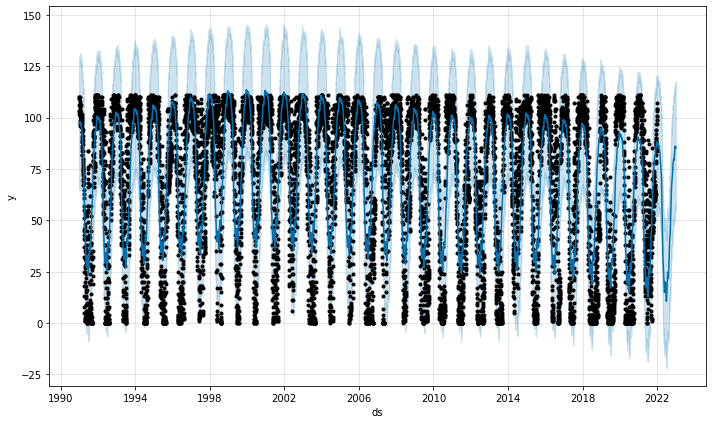

In [142]:
plt.rcParams["figure.figsize"] = (20,3)


fig1 = m.plot(forecast)

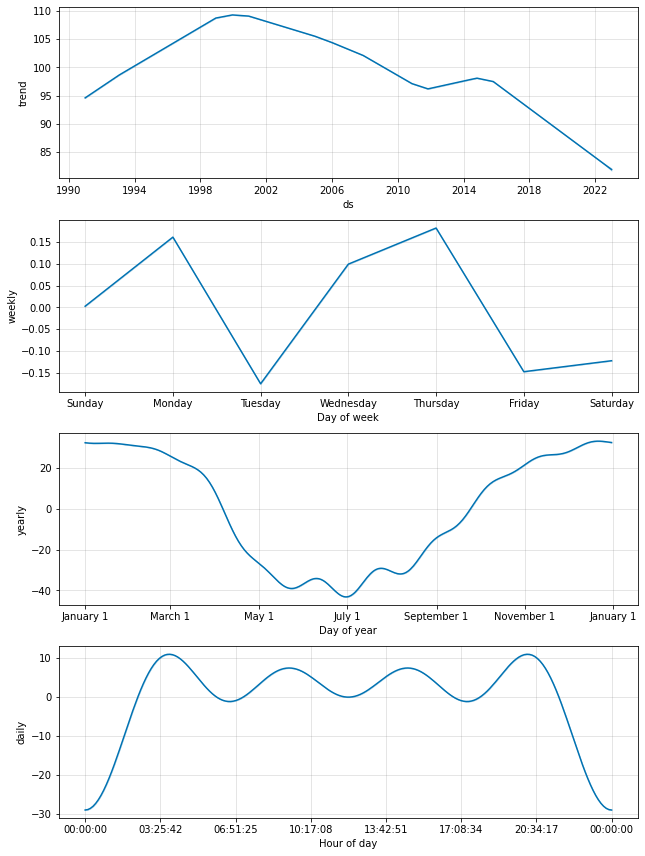

In [143]:
fig2 = m.plot_components(forecast)

In [144]:
prophet_df = forecast.set_index('ds')[['yhat']].join(prophet_df.set_index('ds').y).reset_index()

In [145]:
prophet_df.tail()

ds       yhat   y
11683 2022-12-27  85.475827 NaN
11684 2022-12-28  85.649499 NaN
11685 2022-12-29  85.627655 NaN
11686 2022-12-30  85.193998 NaN
11687 2022-12-31  85.116480 NaN

In [146]:
prophet_df.dropna(inplace=True) #dropping the Nan values at the end of the series

Introducing the cross-validation split to the model. This way it will be better comparable to the other models.

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1825 days', period='30 days', horizon = '30 days')

In [158]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(30)

INFO:prophet:Skipping MAPE because y close to 0


horizon         mse       rmse        mae     mdape     smape  coverage
0   3 days  616.947592  24.838430  18.432008  0.173613  0.439182  0.783755
1   4 days  621.265330  24.925195  18.478771  0.166774  0.438000  0.776371
2   5 days  617.735651  24.854288  18.414208  0.159493  0.439194  0.772152
3   6 days  615.689586  24.813093  18.401249  0.154767  0.445415  0.770042
4   7 days  616.657441  24.832588  18.374408  0.157466  0.447412  0.772152
5   8 days  626.519498  25.030372  18.471995  0.163783  0.449740  0.766878
6   9 days  653.956603  25.572575  18.849211  0.172798  0.455232  0.754219
7  10 days  687.128007  26.213127  19.361399  0.177358  0.464813  0.739451
8  11 days  713.802139  26.717076  19.937192  0.183190  0.474868  0.736287
9  12 days  708.669318  26.620844  20.079484  0.191528  0.473494  0.739451
10 13 days  682.264238  26.120188  19.871089  0.192903  0.468492  0.740506
11 14 days  665.254628  25.792530  19.686594  0.196313  0.465544  0.742616
12 15 days  666.731860  25.821151  19.605967  0.199723  0.468917  0.747890
13 16 days  666.483528  25.816342  19.430483  0.194486  0.466195  0.756329
14 17 days  671.307396  25.909600  19.380220  0.190744  0.464281  0.759494
15 18 days  669.082292  25.866625  19.427429  0.184594  0.463010  0.755274
16 19 days  661.649678  25.722552  19.457671  0.184606  0.460027  0.756329
17 20 days  641.960885  25.336947  19.233663  0.183097  0.454620  0.757384
18 21 days  624.816232  24.996324  18.902518  0.177455  0.447771  0.770042
19 22 days  633.969049  25.178742  19.009663  0.178864  0.449142  0.775316
20 23 days  647.518908  25.446393  19.123526  0.177772  0.449016  0.777426
21 24 days  669.219324  25.869274  19.391672  0.180939  0.453872  0.767932
22 25 days  685.167578  26.175706  19.456988  0.180939  0.460000  0.767932
23 26 days  698.833033  26.435450  19.531182  0.174602  0.466831  0.764768
24 27 days  726.920925  26.961471  19.747429  0.172028  0.471000  0.761603
25 28 days  755.218234  27.481234  20.130977  0.169317  0.475416  0.752110
26 29 days  768.797561  27.727199  20.275329  0.172694  0.475083  0.751055
27 30 days  753.192091  27.444345  20.089164  0.177803  0.471730  0.758439

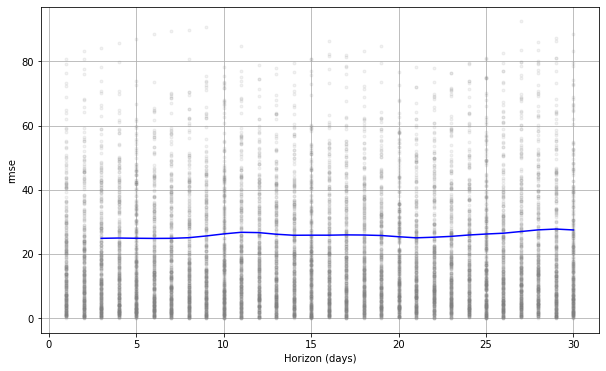

In [159]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

On the 30th day of the forecast the RMSE score is **27.44**. This is a very good score, only the Linear Regression could perform better. Prophet's good attributes to handle non-stationary data well definetaly played an important part in this good performance. However, as we can see on the above plot, the standard deviation could be significant. Prophet is also said to be prone to overfitting, so it is possible that we can make a better final prediction with a model that has lower RMSE score but more reliable performance.

### Random Forest Regression

In order to make the forecast more robust, instead of using a single Decision Tree – which would entail overfitting problems – we chose to apply the random forest model type. The Random Forest model is a collection of decision trees which are working together to achieve a common – in this case forecasting – goal. By employing the decision trees as a whole, the overfitting problem can be reduced and therefore lead to a more confident decision, because the final prediction has a lot less variants and this ultimately leads to a more accurate forecasting. Another reason why the random forest model was chosen for this case study is that it enables better generalization through bagging and random subspaces where the rows and the columns are randomly sampled respectively. This random sampling results in restricted features supplied to each decision tree, so that it does not use the entire set of features, just a random subset.

The main limitation of random forest is that a large number of trees can make the algorithm too slow and ineffective for real-time predictions. In general, these algorithms are fast to train, but quite slow to create predictions once they are trained. They also have well documented limitations with time series regressions, especially with non-stationary series. 

Certainly these limitations played a role in our case as well, as the Random Forest Regressor barely beat our baseline metric. Although it performed slightly better with the root mean squared error score (37.05) and its variance (3.80) as well, it required more computational resources in the process. Certainly the model can be improved with hyperparameter tuning, for instance the number of estimators, the maximum features or the minimum samples per leaf can be optimized. However, as we have more promising models for our prediction it is beneficial to spend more time developing those.

In [148]:
from numpy import asarray
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import warnings

X_orig = uni_df.drop(['BF10'], axis = 1)
y_orig = uni_df.BF10

cvscores = []

# iterating through the cross validation list
for train, test in list(ts_cv.split(X_orig, y_orig)):
  trainX, trainy = asarray(X_orig.iloc[train].values), asarray(y_orig.iloc[train].values)

  model = RandomForestRegressor(n_estimators=1200)
  model.fit(trainX, trainy)

  # adding the error metrics
  yhat = model.predict(X_orig.iloc[test].values)
  rmse = sqrt(mean_squared_error(y_orig.iloc[test].values, yhat))
  mae = mean_absolute_error(y_orig.iloc[test].values, yhat)
  evs = explained_variance_score(y_orig.iloc[test].values, yhat)
  cvscores.append({'rmse': rmse, 'mae': mae, 'evs': evs})

In [149]:
print("RMSE %.2f (+/- %.2f)" % (np.mean(pd.DataFrame(cvscores)['rmse']), np.std(pd.DataFrame(cvscores)['rmse'])))
print("MAE %.2f (+/- %.2f)" % (np.mean(pd.DataFrame(cvscores)['mae']), np.std(pd.DataFrame(cvscores)['mae'])))
print("EVS %.2f (+/- %.2f)" % (np.mean(pd.DataFrame(cvscores)['evs']), np.std(pd.DataFrame(cvscores)['evs'])))

RMSE 37.03 (+/- 3.80)
MAE 25.91 (+/- 3.23)
EVS 0.11 (+/- 0.27)


### ARIMA Model

The next model that is used to contribute to the solution of the forecasting problem is ARIMA (also known as Box–Jenkins models).  due to the fact that the information found in the dataset containing past values of the time series can alone be used for predicting future values. This model captures autocorrelation in a more elaborate way than for e.g. ARMA models; here the autocorrelation is captured directly. Although the ARIMA model is less interpretable than the linear regression model which was introduced previously, it has many advantages which enhance the quality of the forecast. On one hand, this type of model has a strong underlying statistical and mathematical theory, therefore it is easier to generate predictive intervals. On the other hand they are very powerful, because it is possible to find many different types of patterns by using this model. ARIMA is a highly appropriate forecasting algorithm for timeseries analysis, because it assumes that past values provide inherent information.

ARIMA models have three main parameters, indicated as p, d, q; they can be assigned
integer values to indicate the specific ARIMA model that best fits the data set. These components are the following:



1.   p, also known as the lag order, represents the number of lag variables included in the model
2.   d, also known as the degree of differencing, represents the number of times that the raw values in a time series data set are differenced
3.   q, also called the order of moving average, represents the magnitude of the moving average window.

If one of the components does not need to be used, a value of 0 should be assigned to it.

Unfortunately our ARIMA model's performance was very disappointing. It ran for a very long time, and this made the model optimization very difficult, thus the weak end result couldn't be tuned. The suboptimal runtime length was most probably down to the cross validation, as the algorithm had to work its way through the 5 splits of train and test data. This was significantly more difficult for this model than for example for the LSTM models, where batching helps to speed up the learning. Of course at this point cross validation could have been changed to a simpler train-test split but that would have compromised the integrity of the model comparison. 
The model ended up with the root mean squared error of 36.80 with a possible variance of 3.90. These are not significantly better than our baseline and Random Forest scores, so it is certain that we will not use this model for our final prediction. However, if in the future we want to optimize the running of this model we can outsource it to a GPU memory resident. We can use for example Rapids cuDF, which is a Python GPU dataframe library, and it has vastly superior resources than a regular personal computer.

In [329]:
ddd = uni_df.copy()
#ddd['BF10'] = ddd['BF10'].shift(30)
#ddd = ddd.dropna()

In [333]:
from statsmodels.tsa.arima.model import ARIMA

X_orig = uni_df.drop(['BF10'], axis = 1)
y_orig['BF10'] = uni_df['BF10'].shift(30)

cvscores = []
i = 1

# iterating through the cross validation list
for train, test in list(ts_cv.split(ddd.drop(['BF10'], axis = 1), ddd['BF10'])):
    print(i) # <- FOLD number
    print(train)
    print(test)
    
    print(ddd.iloc[train].tail())
    print(ddd.iloc[test].head())
    

    yhat_array = []
    obs_array = []

    history = [x for x in list(ddd['BF10'].iloc[train].values.astype("float"))]
    

    for t in range(0,365):
      model = ARIMA(history, order=(2,1,1))
      model_fit = model.fit()

      output = model_fit.forecast()
      yhat = output[0]
      print(yhat)
      yhat_array.append(yhat)

      obs = list(ddd['BF10'].iloc[test].values.astype("float"))[t]
      next_train = list(ddd['BF10'].iloc[[max(train) + t + 1]].values.astype("float"))
      print(max(train) + t + 1)
      print(ddd.iloc[[max(train) + t + 1]].index)
      history.append(next_train[0])
      print(obs)
      obs_array.append(obs)
    
    # adding the error metrics
    rmse = sqrt(mean_squared_error(obs_array, yhat_array))
    mae = mean_absolute_error(obs_array, yhat_array)
    evs = explained_variance_score(obs_array, yhat_array)
    cvscores.append({'rmse': rmse, 'mae': mae, 'evs': evs})

    i+=1

A streamkimeneten csak az utolsó 5000 sor látható.
4.0
5.654133872225001
7136
DatetimeIndex(['2010-07-16'], dtype='datetime64[ns]', name='DATUM', freq='D')
68.0
4.992068951294222
7137
DatetimeIndex(['2010-07-17'], dtype='datetime64[ns]', name='DATUM', freq='D')
89.0
9.105089688371686
7138
DatetimeIndex(['2010-07-18'], dtype='datetime64[ns]', name='DATUM', freq='D')
94.0
4.819243125655458
7139
DatetimeIndex(['2010-07-19'], dtype='datetime64[ns]', name='DATUM', freq='D')
85.0
3.0236940755996913
7140
DatetimeIndex(['2010-07-20'], dtype='datetime64[ns]', name='DATUM', freq='D')
76.0
1.107265985200998
7141
DatetimeIndex(['2010-07-21'], dtype='datetime64[ns]', name='DATUM', freq='D')
67.0
15.41120018953656
7142
DatetimeIndex(['2010-07-22'], dtype='datetime64[ns]', name='DATUM', freq='D')
61.0
11.565302264693152
7143
DatetimeIndex(['2010-07-23'], dtype='datetime64[ns]', name='DATUM', freq='D')
69.0
9.723647256796967
7144
DatetimeIndex(['2010-07-24'], dtype='datetime64[ns]', name='DATUM', freq

In [334]:
print("RMSE %.2f (+/- %.2f)" % (np.mean(pd.DataFrame(cvscores)['rmse']), np.std(pd.DataFrame(cvscores)['rmse'])))
print("MAE %.2f (+/- %.2f)" % (np.mean(pd.DataFrame(cvscores)['mae']), np.std(pd.DataFrame(cvscores)['mae'])))
print("EVS %.2f (+/- %.2f)" % (np.mean(pd.DataFrame(cvscores)['evs']), np.std(pd.DataFrame(cvscores)['evs'])))

RMSE 36.80 (+/- 3.90)
MAE 24.17 (+/- 4.08)
EVS -0.02 (+/- 0.50)


### Deep Learning Models



In the last part of the modelling phase we will introduce the deep learning models, specifically models with long short-term memomry or LSTM layers. According to Swamynathan (2017):

> LSTM is an implementation of improved RNN architecture to address the issues of
general RNN, and it enables long-range dependencies. It is designed to have better
memory through linear memory cells surrounded by a set of gate units used to control
the flow of information, when information should enter the memory, when to forget, and
when to output. It uses no activation function within its recurrent components, thus the
gradient term does not vanish with back propagation.

The four deep learning models have some similar specifications, for example they all contain an LSTM and a Dense layer. They all use the `createDataset` function we define below. In every case we iterate through a 5 fold cross validation list. The datasets are normalized by a `MinMaxScaler` between 0 and 1 during the learning phase than rescaled for the error metric. We also introduced an `EarlyStopping` function with a patience of 20 to stop the model running unnecessary. The differences of the respective models come in the types and number of layers they implement and their hyperparameters. 

Naturally, as all other deep learning model, the LSTM has its limitations. Although it was developed back in 1997 to tackle the vanishing gradient problem, it still doesn't perform perfectly in this regard. Furthermore, because of its linear layers it has a long runtime and it has a tendency to overfit.

Initially the CNN model performed the worst out of the 4 LSTM models. However, it was also the one that reacted best to the hyperparameter tuning, so eventually we chose this model to perform the final prediction of our project. Although the Linear Regression model had a better root mean squared error score, it also had higher variance, and a high risk of overfitting, thus the CNN model seemed to be a more reliable choice to make the forecast.

The basis of the code for the models comes from this Kaggle notebook: https://www.kaggle.com/code/ritesh7355/develop-lstm-models-for-time-series-forecasting

##### Helper functions

In [219]:
def createDataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step - 30):
		dataX.append(dataset[i:(i+time_step)])
		dataY.append(dataset[i + time_step + 30])
	return np.array(dataX), np.array(dataY)

#### Vanilla LSTM

Vanilla LSTM is a model which consists of a single layer of LSTM units and an output layer which is used to make the prediction. This network has a visible layer with 64 neurons and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs, and a batch size of 32 is used.

In [220]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

With the help of the `drive.mount` and the `model.save` function we were able to save the models and check their performance easily. This played an important role during the modelling phase, but it is not necessary after finishing the project, thus these functions are commented out from the code. 

In [72]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


1
Train data size:  (5818, 1)
(5758, 30, 1) (5758, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
180/180 [==============================] - 5s 20ms/step - loss: 0.1009 - val_loss: 0.0867
Epoch 2/70
180/180 [==============================] - 5s 30ms/step - loss: 0.0782 - val_loss: 0.0818
Epoch 3/70
180/180 [==============================] - 7s 39ms/step - loss: 0.0736 - val_loss: 0.0815
Epoch 4/70
180/180 [==============================] - 4s 20ms/step - loss: 0.0730 - val_loss: 0.0826
Epoch 5/70
180/180 [==============================] - 3s 19ms/step - loss: 0.0724 - val_loss: 0.0822
Epoch 6/70
180/180 [==============================] - 3s 19ms/step - loss: 0.0724 - val_loss: 0.0823
Epoch 7/70
180/180 [==============================] - 3s 17ms/step - loss: 0.0722 - val_loss: 0.0839
Epoch 8/70
180/180 [==============================] - 3s 17ms/step - loss: 0.0724 - val_loss: 0.0822
Epoch 9/70
180/180 [==============================] - 3s 18ms/step - loss: 0.0724 - val_loss: 0.0851
Epoch 10/70
1

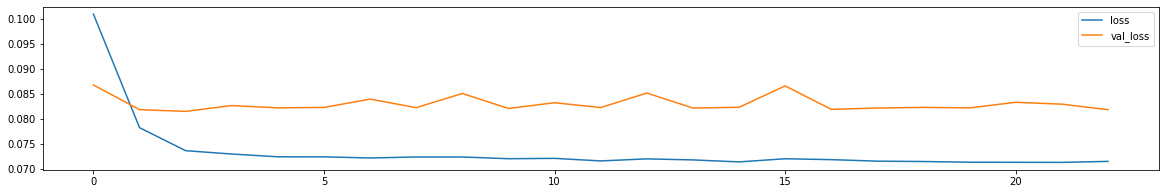

2
Train data size:  (6913, 1)
(6853, 30, 1) (6853, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
215/215 [==============================] - 5s 17ms/step - loss: 0.2404 - val_loss: 0.1219
Epoch 2/70
215/215 [==============================] - 4s 17ms/step - loss: 0.0864 - val_loss: 0.1125
Epoch 3/70
215/215 [==============================] - 4s 17ms/step - loss: 0.0802 - val_loss: 0.0996
Epoch 4/70
215/215 [==============================] - 6s 27ms/step - loss: 0.0760 - val_loss: 0.0877
Epoch 5/70
215/215 [==============================] - 4s 17ms/step - loss: 0.0739 - val_loss: 0.0885
Epoch 6/70
215/215 [==============================] - 4s 19ms/step - loss: 0.0731 - val_loss: 0.0847
Epoch 7/70
215/215 [==============================] - 4s 19ms/step - loss: 0.0734 - val_loss: 0.0860
Epoch 8/70
215/215 [==============================] - 4s 18ms/step - loss: 0.0731 - val_loss: 0.0828
Epoch 9/70
215/215 [==============================] - 4s 19ms/step - loss: 0.0736 - val_loss: 0.0855
Epoch 10/70
2

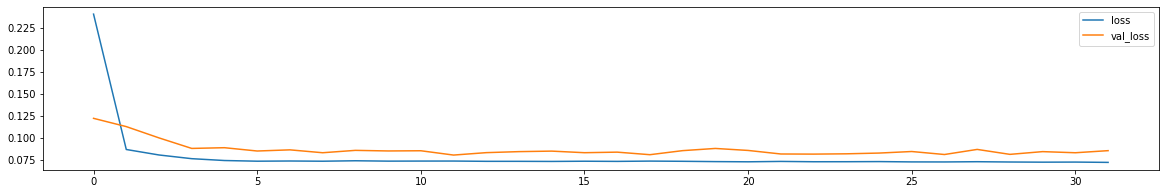

3
Train data size:  (8008, 1)
(7948, 30, 1) (7948, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
249/249 [==============================] - 7s 20ms/step - loss: 0.1095 - val_loss: 0.0909
Epoch 2/70
249/249 [==============================] - 5s 20ms/step - loss: 0.0796 - val_loss: 0.0713
Epoch 3/70
249/249 [==============================] - 5s 19ms/step - loss: 0.0746 - val_loss: 0.0743
Epoch 4/70
249/249 [==============================] - 5s 18ms/step - loss: 0.0748 - val_loss: 0.0707
Epoch 5/70
249/249 [==============================] - 4s 18ms/step - loss: 0.0747 - val_loss: 0.0694
Epoch 6/70
249/249 [==============================] - 4s 18ms/step - loss: 0.0744 - val_loss: 0.0676
Epoch 7/70
249/249 [==============================] - 4s 18ms/step - loss: 0.0745 - val_loss: 0.0676
Epoch 8/70
249/249 [==============================] - 5s 19ms/step - loss: 0.0739 - val_loss: 0.0678
Epoch 9/70
249/249 [==============================] - 4s 17ms/step - loss: 0.0737 - val_loss: 0.0683
Epoch 10/70
2

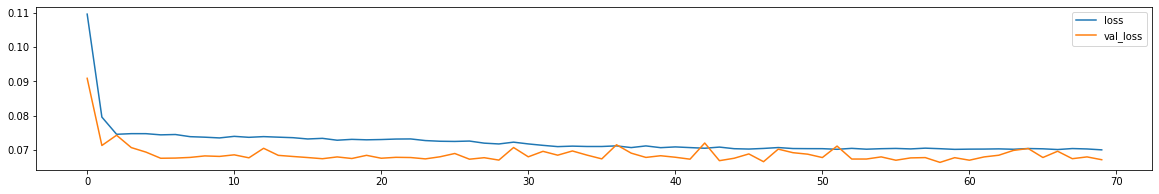

4
Train data size:  (9103, 1)
(9043, 30, 1) (9043, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
283/283 [==============================] - 6s 15ms/step - loss: 0.1258 - val_loss: 0.1144
Epoch 2/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0810 - val_loss: 0.0955
Epoch 3/70
283/283 [==============================] - 6s 20ms/step - loss: 0.0747 - val_loss: 0.0945
Epoch 4/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0733 - val_loss: 0.0880
Epoch 5/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0727 - val_loss: 0.0870
Epoch 6/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0730 - val_loss: 0.0912
Epoch 7/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0728 - val_loss: 0.0865
Epoch 8/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0730 - val_loss: 0.0879
Epoch 9/70
283/283 [==============================] - 4s 15ms/step - loss: 0.0732 - val_loss: 0.0884
Epoch 10/70
2

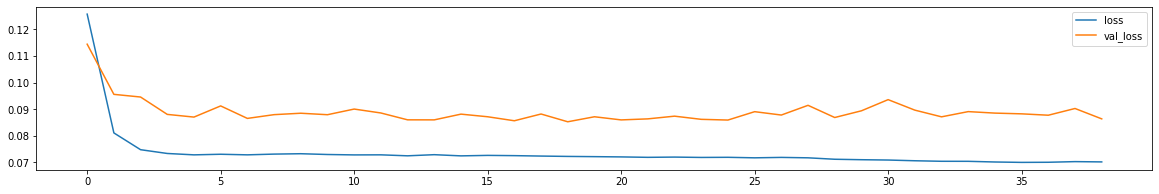

5
Train data size:  (10198, 1)
(10138, 30, 1) (10138, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
317/317 [==============================] - 6s 16ms/step - loss: 0.1368 - val_loss: 0.1078
Epoch 2/70
317/317 [==============================] - 5s 15ms/step - loss: 0.0810 - val_loss: 0.0907
Epoch 3/70
317/317 [==============================] - 5s 15ms/step - loss: 0.0744 - val_loss: 0.0833
Epoch 4/70
317/317 [==============================] - 5s 17ms/step - loss: 0.0741 - val_loss: 0.0875
Epoch 5/70
317/317 [==============================] - 6s 17ms/step - loss: 0.0738 - val_loss: 0.0810
Epoch 6/70
317/317 [==============================] - 7s 22ms/step - loss: 0.0738 - val_loss: 0.0842
Epoch 7/70
317/317 [==============================] - 6s 18ms/step - loss: 0.0737 - val_loss: 0.0865
Epoch 8/70
317/317 [==============================] - 6s 18ms/step - loss: 0.0739 - val_loss: 0.0812
Epoch 9/70
317/317 [==============================] - 6s 18ms/step - loss: 0.0737 - val_loss: 0.0835
Epoch 10/7

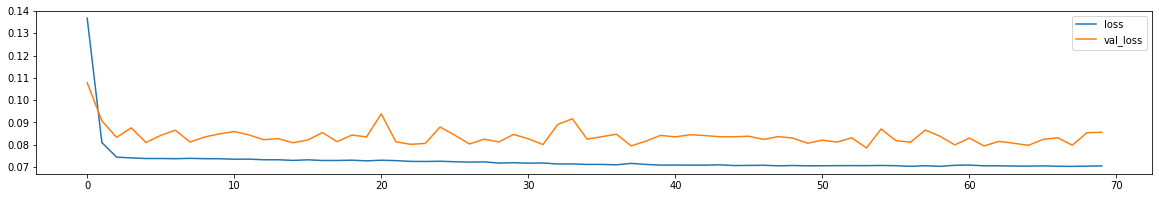

In [221]:
i = 1

X_orig = uni_df
y_orig = uni_df.BF10

cvscores = []

# iterating through the cross validation list
for train, test in list(ts_cv.split(X_orig, y_orig)):
    print(i) # <- FOLD number
    
    n_past = 30
    dataSize_train = len(y_orig.iloc[train])
    dataSize_test = len(y_orig.iloc[test])
    y_dat_train = y_orig.iloc[train].values.reshape(dataSize_train,1)
    y_dat_test = y_orig.iloc[test].values.reshape(dataSize_test,1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_y_dat_train = scaler.fit_transform(y_dat_train)
    scaled_y_dat_test = scaler.fit_transform(y_dat_test)
    
    print('Train data size: ', scaled_y_dat_train.shape)
    
    X_train,y_train = createDataset(scaled_y_dat_train, time_step=n_past)
    X_val,y_val = createDataset(scaled_y_dat_test, time_step=n_past)
    
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)

    n_features = 1
    n_steps = 30
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model = Sequential()
    model.add(LSTM(32, activation='sigmoid', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=70,batch_size=32,verbose=1, callbacks=[callback], workers=4)

    #model_name = './drive/MyDrive/Models/vanilla_lstm_' + str(i)
    #model.save(model_name)
    #print(model.summary())
    
    y_val_hat = scaler.inverse_transform(history.model.predict(X_val))
    y_val_original = scaler.inverse_transform(y_val)
    
    # adding the error metric
    rmse = sqrt(mean_squared_error(y_val_original, y_val_hat))
    print(rmse)
    
    #fold_max_val_loss = max(history.history['val_loss'])

    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    cvscores.append(rmse)
    
    i+=1

In [320]:
print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))

30.49 (+/- 1.22)


#### Stacked LSTM

This model type is an extended version of the standard LSTM model: instead of having only one LSTM layer, the Stacked LSTM model consists of multiple LSTM layers and each of those layers have multiple memory cells. The reason to apply this multi-layer approach is to increase the deepness and complexity of the model and therefore contributes to the model being more successful in predicting.

1
Train data size:  (5818, 1)
(5758, 30, 1) (5758, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
180/180 [==============================] - 13s 57ms/step - loss: 0.1157 - val_loss: 0.0837
Epoch 2/70
180/180 [==============================] - 8s 46ms/step - loss: 0.0717 - val_loss: 0.0809
Epoch 3/70
180/180 [==============================] - 6s 34ms/step - loss: 0.0705 - val_loss: 0.0812
Epoch 4/70
180/180 [==============================] - 6s 34ms/step - loss: 0.0708 - val_loss: 0.0804
Epoch 5/70
180/180 [==============================] - 6s 34ms/step - loss: 0.0704 - val_loss: 0.0802
Epoch 6/70
180/180 [==============================] - 6s 34ms/step - loss: 0.0699 - val_loss: 0.0822
Epoch 7/70
180/180 [==============================] - 8s 43ms/step - loss: 0.0703 - val_loss: 0.0814
Epoch 8/70
180/180 [==============================] - 6s 34ms/step - loss: 0.0696 - val_loss: 0.0806
Epoch 9/70
180/180 [==============================] - 6s 34ms/step - loss: 0.0699 - val_loss: 0.0805
Epoch 10/70


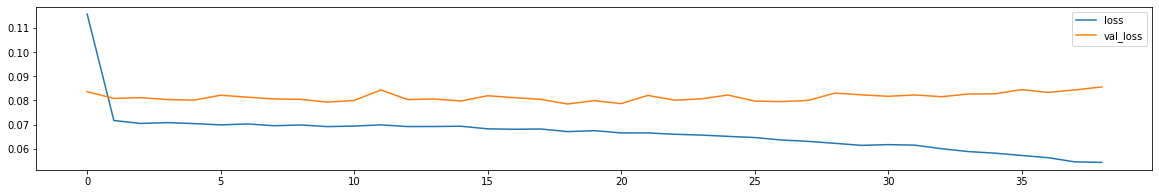

2
Train data size:  (6913, 1)
(6853, 30, 1) (6853, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
215/215 [==============================] - 10s 35ms/step - loss: 0.0925 - val_loss: 0.0865
Epoch 2/70
215/215 [==============================] - 7s 33ms/step - loss: 0.0733 - val_loss: 0.0853
Epoch 3/70
215/215 [==============================] - 7s 33ms/step - loss: 0.0736 - val_loss: 0.0811
Epoch 4/70
215/215 [==============================] - 7s 33ms/step - loss: 0.0718 - val_loss: 0.0933
Epoch 5/70
215/215 [==============================] - 7s 33ms/step - loss: 0.0727 - val_loss: 0.0827
Epoch 6/70
215/215 [==============================] - 7s 33ms/step - loss: 0.0720 - val_loss: 0.0796
Epoch 7/70
215/215 [==============================] - 7s 34ms/step - loss: 0.0716 - val_loss: 0.0828
Epoch 8/70
215/215 [==============================] - 7s 34ms/step - loss: 0.0715 - val_loss: 0.0871
Epoch 9/70
215/215 [==============================] - 7s 34ms/step - loss: 0.0720 - val_loss: 0.0839
Epoch 10/70


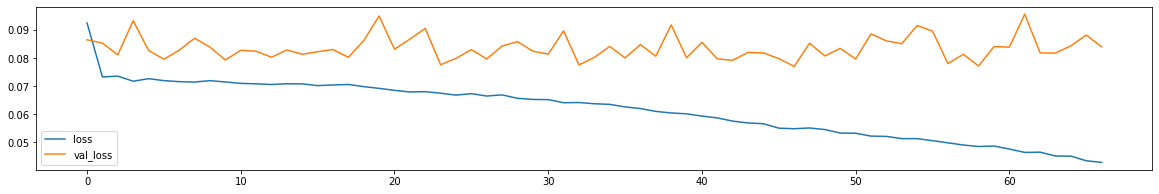

3
Train data size:  (8008, 1)
(7948, 30, 1) (7948, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
249/249 [==============================] - 12s 35ms/step - loss: 0.0899 - val_loss: 0.0765
Epoch 2/70
249/249 [==============================] - 8s 34ms/step - loss: 0.0738 - val_loss: 0.0729
Epoch 3/70
249/249 [==============================] - 8s 34ms/step - loss: 0.0740 - val_loss: 0.0704
Epoch 4/70
249/249 [==============================] - 8s 33ms/step - loss: 0.0731 - val_loss: 0.0696
Epoch 5/70
249/249 [==============================] - 8s 34ms/step - loss: 0.0731 - val_loss: 0.0693
Epoch 6/70
249/249 [==============================] - 8s 33ms/step - loss: 0.0721 - val_loss: 0.0746
Epoch 7/70
249/249 [==============================] - 8s 33ms/step - loss: 0.0722 - val_loss: 0.0693
Epoch 8/70
249/249 [==============================] - 8s 33ms/step - loss: 0.0718 - val_loss: 0.0679
Epoch 9/70
249/249 [==============================] - 8s 33ms/step - loss: 0.0721 - val_loss: 0.0713
Epoch 10/70


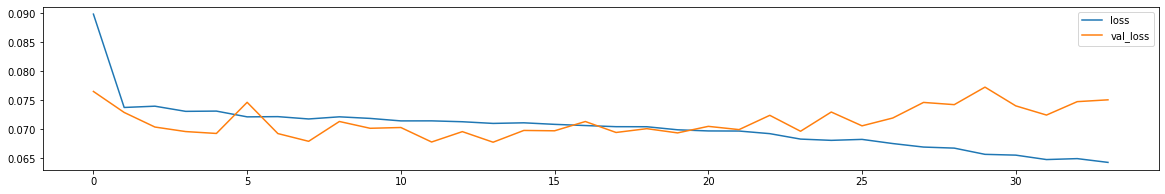

4
Train data size:  (9103, 1)
(9043, 30, 1) (9043, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
283/283 [==============================] - 13s 37ms/step - loss: 0.0933 - val_loss: 0.0920
Epoch 2/70
283/283 [==============================] - 9s 33ms/step - loss: 0.0735 - val_loss: 0.0903
Epoch 3/70
283/283 [==============================] - 10s 34ms/step - loss: 0.0729 - val_loss: 0.0905
Epoch 4/70
283/283 [==============================] - 10s 34ms/step - loss: 0.0721 - val_loss: 0.0881
Epoch 5/70
283/283 [==============================] - 9s 33ms/step - loss: 0.0718 - val_loss: 0.0897
Epoch 6/70
283/283 [==============================] - 9s 33ms/step - loss: 0.0716 - val_loss: 0.0874
Epoch 7/70
283/283 [==============================] - 9s 33ms/step - loss: 0.0715 - val_loss: 0.0898
Epoch 8/70
283/283 [==============================] - 10s 34ms/step - loss: 0.0718 - val_loss: 0.0942
Epoch 9/70
283/283 [==============================] - 10s 34ms/step - loss: 0.0712 - val_loss: 0.0900
Epoch 10

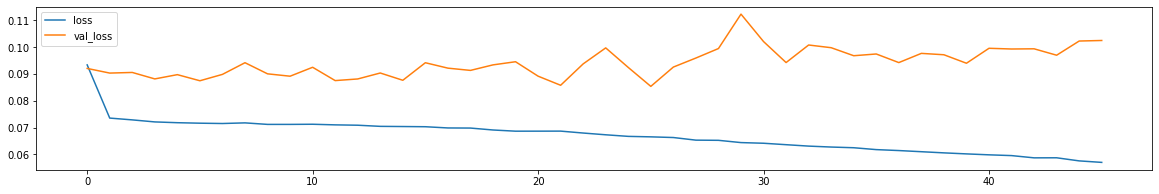

5
Train data size:  (10198, 1)
(10138, 30, 1) (10138, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
317/317 [==============================] - 14s 37ms/step - loss: 0.0873 - val_loss: 0.0993
Epoch 2/70
317/317 [==============================] - 11s 35ms/step - loss: 0.0742 - val_loss: 0.0868
Epoch 3/70
317/317 [==============================] - 11s 35ms/step - loss: 0.0734 - val_loss: 0.0921
Epoch 4/70
317/317 [==============================] - 11s 35ms/step - loss: 0.0730 - val_loss: 0.0847
Epoch 5/70
317/317 [==============================] - 11s 36ms/step - loss: 0.0723 - val_loss: 0.0844
Epoch 6/70
317/317 [==============================] - 13s 41ms/step - loss: 0.0723 - val_loss: 0.0910
Epoch 7/70
317/317 [==============================] - 11s 36ms/step - loss: 0.0722 - val_loss: 0.0816
Epoch 8/70
317/317 [==============================] - 11s 35ms/step - loss: 0.0722 - val_loss: 0.0841
Epoch 9/70
317/317 [==============================] - 11s 36ms/step - loss: 0.0720 - val_loss: 0.0798
E

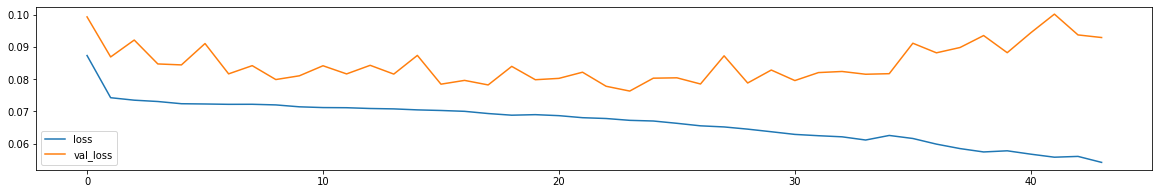

In [222]:
i = 1

X_orig = uni_df
y_orig = uni_df.BF10

cvscores = []

# iterating through the cross validation list
for train, test in list(ts_cv.split(X_orig, y_orig)):
    print(i) # <- FOLD number
    
    n_past = 30
    dataSize_train = len(y_orig.iloc[train])
    dataSize_test = len(y_orig.iloc[test])
    y_dat_train = y_orig.iloc[train].values.reshape(dataSize_train,1)
    y_dat_test = y_orig.iloc[test].values.reshape(dataSize_test,1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_y_dat_train = scaler.fit_transform(y_dat_train)
    scaled_y_dat_test = scaler.fit_transform(y_dat_test)
    
    print('Train data size: ', scaled_y_dat_train.shape)
    
    X_train,y_train = createDataset(scaled_y_dat_train, time_step=n_past)
    X_val,y_val = createDataset(scaled_y_dat_test, time_step=n_past)
    
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)
    
    n_features = 1
    n_steps = 30

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=70,batch_size=32,verbose=1, callbacks=[callback], workers=4)

    #model_name = './drive/MyDrive/Models/stacked_lstm_' + str(i)
    #model.save(model_name)
    
    y_val_hat = scaler.inverse_transform(history.model.predict(X_val))
    y_val_original = scaler.inverse_transform(y_val)
    
    # adding the error metric
    rmse = sqrt(mean_squared_error(y_val_original, y_val_hat))
    print(rmse)
    
    #fold_max_val_loss = max(history.history['val_loss'])

    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    cvscores.append(rmse)
    
    i+=1

In [227]:
print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))

29.84 (+/- 1.24)


#### Bidirectional LSTM

Bidirectional LSTM is a recurrent model where the input flows both forward and backward and it is therefore possible to use information from both directions. This is achieved by adding an extra LSTM layer, so Bidirectional LSTMs have a forward recurrent component and a backward recurrent component. The difference between the two components is basically that in the backward component we are computing the hidden and cell states in a reverse-chronological order.

1
Train data size:  (5818, 1)
(5758, 30, 1) (5758, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
180/180 [==============================] - 10s 41ms/step - loss: 0.0879 - val_loss: 0.0814
Epoch 2/70
180/180 [==============================] - 7s 39ms/step - loss: 0.0735 - val_loss: 0.0852
Epoch 3/70
180/180 [==============================] - 7s 39ms/step - loss: 0.0734 - val_loss: 0.0805
Epoch 4/70
180/180 [==============================] - 7s 40ms/step - loss: 0.0714 - val_loss: 0.0796
Epoch 5/70
180/180 [==============================] - 7s 40ms/step - loss: 0.0709 - val_loss: 0.0808
Epoch 6/70
180/180 [==============================] - 7s 39ms/step - loss: 0.0711 - val_loss: 0.0807
Epoch 7/70
180/180 [==============================] - 7s 39ms/step - loss: 0.0707 - val_loss: 0.0851
Epoch 8/70
180/180 [==============================] - 7s 40ms/step - loss: 0.0704 - val_loss: 0.0793
Epoch 9/70
180/180 [==============================] - 7s 39ms/step - loss: 0.0700 - val_loss: 0.0849
Epoch 10/70


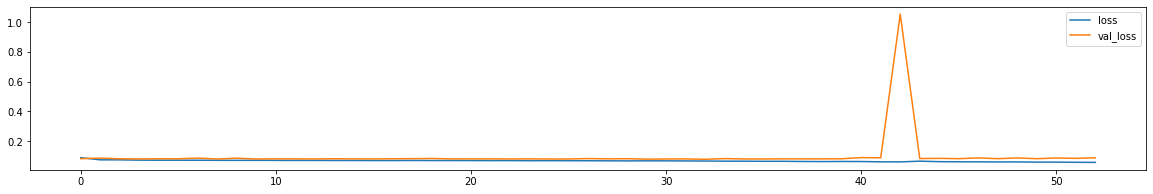

2
Train data size:  (6913, 1)
(6853, 30, 1) (6853, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
215/215 [==============================] - 15s 58ms/step - loss: 0.0947 - val_loss: 0.0859
Epoch 2/70
215/215 [==============================] - 10s 45ms/step - loss: 0.0751 - val_loss: 0.0926
Epoch 3/70
215/215 [==============================] - 9s 44ms/step - loss: 0.0746 - val_loss: 0.0815
Epoch 4/70
215/215 [==============================] - 9s 41ms/step - loss: 0.0740 - val_loss: 0.0779
Epoch 5/70
215/215 [==============================] - 9s 40ms/step - loss: 0.0734 - val_loss: 0.0833
Epoch 6/70
215/215 [==============================] - 9s 42ms/step - loss: 0.0719 - val_loss: 0.0887
Epoch 7/70
215/215 [==============================] - 11s 51ms/step - loss: 0.0722 - val_loss: 0.0829
Epoch 8/70
215/215 [==============================] - 10s 47ms/step - loss: 0.0713 - val_loss: 0.0807
Epoch 9/70
215/215 [==============================] - 9s 44ms/step - loss: 0.0716 - val_loss: 0.0854
Epoch 10/

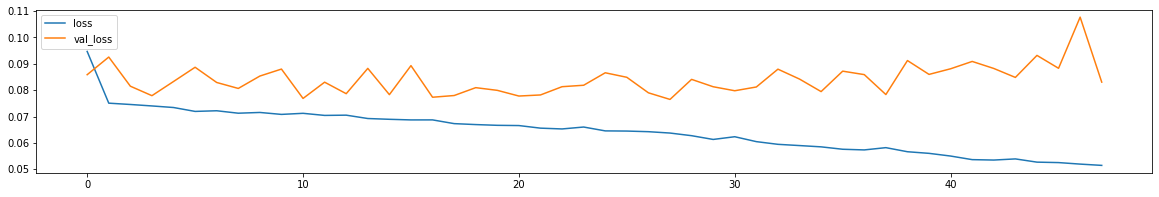

3
Train data size:  (8008, 1)
(7948, 30, 1) (7948, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
249/249 [==============================] - 18s 57ms/step - loss: 0.0874 - val_loss: 0.0710
Epoch 2/70
249/249 [==============================] - 13s 53ms/step - loss: 0.0750 - val_loss: 0.0686
Epoch 3/70
249/249 [==============================] - 12s 50ms/step - loss: 0.0739 - val_loss: 0.0692
Epoch 4/70
249/249 [==============================] - 13s 52ms/step - loss: 0.0728 - val_loss: 0.0707
Epoch 5/70
249/249 [==============================] - 12s 48ms/step - loss: 0.0735 - val_loss: 0.0698
Epoch 6/70
249/249 [==============================] - 11s 43ms/step - loss: 0.0720 - val_loss: 0.0698
Epoch 7/70
249/249 [==============================] - 12s 48ms/step - loss: 0.0724 - val_loss: 0.0677
Epoch 8/70
249/249 [==============================] - 12s 48ms/step - loss: 0.0719 - val_loss: 0.0721
Epoch 9/70
249/249 [==============================] - 10s 42ms/step - loss: 0.0714 - val_loss: 0.0692
Epoc

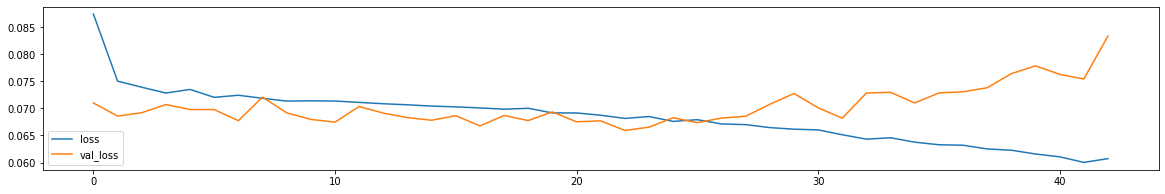

4
Train data size:  (9103, 1)
(9043, 30, 1) (9043, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
283/283 [==============================] - 15s 43ms/step - loss: 0.0892 - val_loss: 0.0898
Epoch 2/70
283/283 [==============================] - 11s 40ms/step - loss: 0.0746 - val_loss: 0.0992
Epoch 3/70
283/283 [==============================] - 12s 43ms/step - loss: 0.0738 - val_loss: 0.0899
Epoch 4/70
283/283 [==============================] - 11s 40ms/step - loss: 0.0732 - val_loss: 0.0899
Epoch 5/70
283/283 [==============================] - 11s 39ms/step - loss: 0.0722 - val_loss: 0.0893
Epoch 6/70
283/283 [==============================] - 13s 44ms/step - loss: 0.0721 - val_loss: 0.0873
Epoch 7/70
283/283 [==============================] - 15s 53ms/step - loss: 0.0716 - val_loss: 0.0895
Epoch 8/70
283/283 [==============================] - 14s 48ms/step - loss: 0.0707 - val_loss: 0.0904
Epoch 9/70
283/283 [==============================] - 14s 49ms/step - loss: 0.0714 - val_loss: 0.0885
Epoc

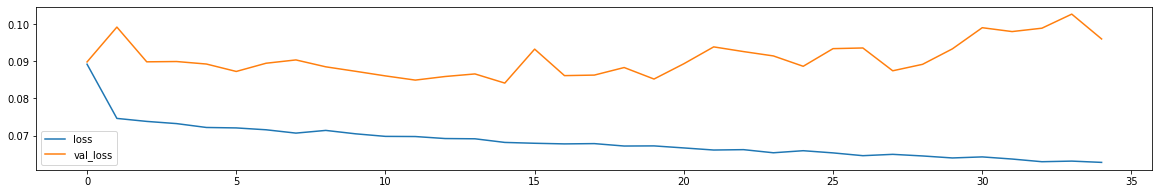

5
Train data size:  (10198, 1)
(10138, 30, 1) (10138, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
317/317 [==============================] - 15s 40ms/step - loss: 0.0851 - val_loss: 0.0836
Epoch 2/70
317/317 [==============================] - 12s 38ms/step - loss: 0.0747 - val_loss: 0.0924
Epoch 3/70
317/317 [==============================] - 12s 39ms/step - loss: 0.0744 - val_loss: 0.0950
Epoch 4/70
317/317 [==============================] - 12s 39ms/step - loss: 0.0734 - val_loss: 0.0803
Epoch 5/70
317/317 [==============================] - 12s 38ms/step - loss: 0.0733 - val_loss: 0.0872
Epoch 6/70
317/317 [==============================] - 14s 44ms/step - loss: 0.0724 - val_loss: 0.0804
Epoch 7/70
317/317 [==============================] - 12s 38ms/step - loss: 0.0720 - val_loss: 0.0837
Epoch 8/70
317/317 [==============================] - 12s 39ms/step - loss: 0.0723 - val_loss: 0.0792
Epoch 9/70
317/317 [==============================] - 12s 39ms/step - loss: 0.0720 - val_loss: 0.0826
E

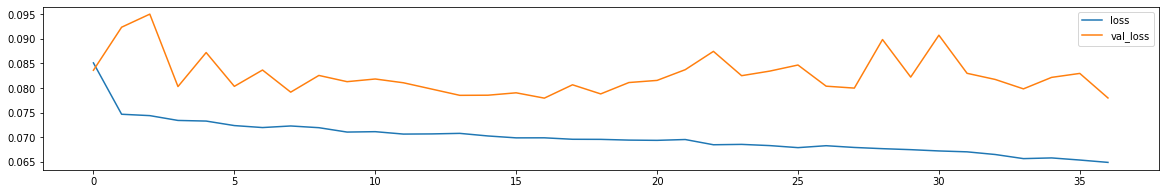

In [223]:
from keras.layers import Bidirectional

i = 1

X_orig = uni_df
y_orig = uni_df.BF10

cvscores = []

# iterating through the cross validation list
for train, test in list(ts_cv.split(X_orig, y_orig)):
    print(i) # <- FOLD number
    
    n_past = 30
    dataSize_train = len(y_orig.iloc[train])
    dataSize_test = len(y_orig.iloc[test])
    y_dat_train = y_orig.iloc[train].values.reshape(dataSize_train,1)
    y_dat_test = y_orig.iloc[test].values.reshape(dataSize_test,1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_y_dat_train = scaler.fit_transform(y_dat_train)
    scaled_y_dat_test = scaler.fit_transform(y_dat_test)
    
    print('Train data size: ', scaled_y_dat_train.shape)
    
    X_train,y_train = createDataset(scaled_y_dat_train, time_step=n_past)
    X_val,y_val = createDataset(scaled_y_dat_test, time_step=n_past)
    
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)

    n_features = 1
    n_steps = 30
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model = Sequential()
    model.add(Bidirectional(LSTM(96, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=70,batch_size=32,verbose=1, callbacks=[callback], workers=4)

    #model_name = './drive/MyDrive/Models/bidirectional_lstm_' + str(i)
    #model.save(model_name)
    
    y_val_hat = scaler.inverse_transform(history.model.predict(X_val))
    y_val_original = scaler.inverse_transform(y_val)
    
    # adding the error metric
    rmse = sqrt(mean_squared_error(y_val_original, y_val_hat))
    print(rmse)
    
    #fold_max_val_loss = max(history.history['val_loss'])

    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    cvscores.append(rmse)
    
    i+=1

In [224]:
print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))

30.65 (+/- 1.20)


#### CNN LSTM

Convolutional Neural Network originally specializes in processing data having grid a pattern, such as images. However, the network's dilated convolutions make it applicable for forecasting time series. In case of this model, CNN and LSTM layers are combined: the LSTM layer handles sequential dependencies in the time series and the CNN layer provides information by using dilated convolution to have a better understanding of the relationships between the times series observations.

From the 4 LSTM models the convolutional one's tuning process proved to be the most effective. Even though it produced an initial RMSE score of 31.59, thanks to the hyperparameter tuning it went down to 30.32 eventually. 

The tuning process was the same as with the other deep learning models. First, the epoch value was kept low and the batch size was higher. This setup helped to run our model quicker and that was crucial in the experimental phase. In this phase, through a trial and error process all the other hyperparameters were optimized. The first significant improvement came when padding, kernel size and strides were introduced to the model and the size of the LSTM layer was reduced from 64 to 32. After that a Dropout layer was introduced and optimized in multiple steps to the final rate of 0.1. This helped to improve our score but interestingly it increased the standard deviation as well. After that a trial and error process continued with finding the optimal activation functions and optimizer. Unexpectedly, the model performed better with the RMSprop optimizer than with adam, which is currently the most popular optimizer. The Stochastic Gradient Descent optimizer also underperformed compared to RMSprop. Finally, the batch size was reduced to 16 and the epoch number was increased to 70. The model did not need more epochs as the callback function usually stopped the learning before reaching 70. 

In the end, these changes not only improved the RMSE score of the model but also treated the initial overfitting problem, as we can see on the correlation of the loss and validation loss scores.

1
Train data size:  (5818, 1)
(5758, 30, 1) (5758, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
360/360 [==============================] - 4s 5ms/step - loss: 0.0763 - val_loss: 0.0926
Epoch 2/70
360/360 [==============================] - 2s 5ms/step - loss: 0.0720 - val_loss: 0.0889
Epoch 3/70
360/360 [==============================] - 2s 5ms/step - loss: 0.0706 - val_loss: 0.0889
Epoch 4/70
360/360 [==============================] - 2s 5ms/step - loss: 0.0699 - val_loss: 0.0831
Epoch 5/70
360/360 [==============================] - 3s 7ms/step - loss: 0.0691 - val_loss: 0.0838
Epoch 6/70
360/360 [==============================] - 2s 6ms/step - loss: 0.0692 - val_loss: 0.0788
Epoch 7/70
360/360 [==============================] - 2s 5ms/step - loss: 0.0686 - val_loss: 0.0833
Epoch 8/70
360/360 [==============================] - 2s 5ms/step - loss: 0.0686 - val_loss: 0.0815
Epoch 9/70
360/360 [==============================] - 2s 5ms/step - loss: 0.0684 - val_loss: 0.0854
Epoch 10/70
360/360 [=

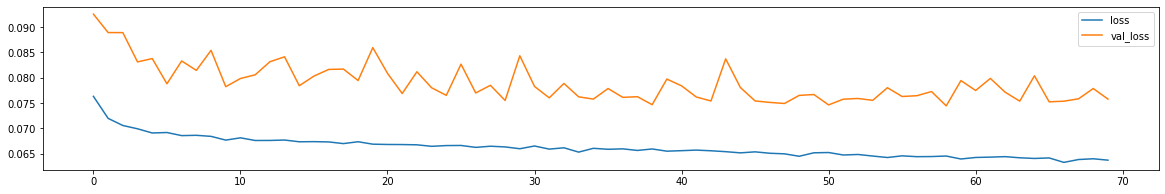

2
Train data size:  (6913, 1)
(6853, 30, 1) (6853, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
429/429 [==============================] - 4s 5ms/step - loss: 0.0794 - val_loss: 0.1023
Epoch 2/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0721 - val_loss: 0.0855
Epoch 3/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0703 - val_loss: 0.0791
Epoch 4/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0696 - val_loss: 0.0907
Epoch 5/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0699 - val_loss: 0.0906
Epoch 6/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0693 - val_loss: 0.0768
Epoch 7/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0690 - val_loss: 0.0976
Epoch 8/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0686 - val_loss: 0.0784
Epoch 9/70
429/429 [==============================] - 2s 5ms/step - loss: 0.0687 - val_loss: 0.0798
Epoch 10/70
429/429 [=

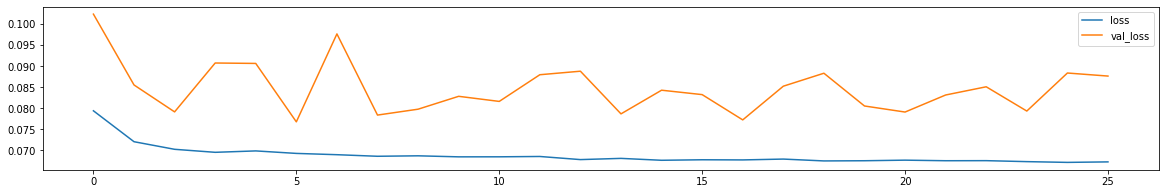

3
Train data size:  (8008, 1)
(7948, 30, 1) (7948, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
497/497 [==============================] - 5s 6ms/step - loss: 0.0858 - val_loss: 0.0830
Epoch 2/70
497/497 [==============================] - 2s 5ms/step - loss: 0.0750 - val_loss: 0.0686
Epoch 3/70
497/497 [==============================] - 3s 5ms/step - loss: 0.0738 - val_loss: 0.0668
Epoch 4/70
497/497 [==============================] - 3s 6ms/step - loss: 0.0729 - val_loss: 0.0772
Epoch 5/70
497/497 [==============================] - 3s 6ms/step - loss: 0.0723 - val_loss: 0.0680
Epoch 6/70
497/497 [==============================] - 3s 5ms/step - loss: 0.0718 - val_loss: 0.0709
Epoch 7/70
497/497 [==============================] - 3s 5ms/step - loss: 0.0714 - val_loss: 0.0908
Epoch 8/70
497/497 [==============================] - 3s 6ms/step - loss: 0.0713 - val_loss: 0.0661
Epoch 9/70
497/497 [==============================] - 3s 6ms/step - loss: 0.0709 - val_loss: 0.0676
Epoch 10/70
497/497 [=

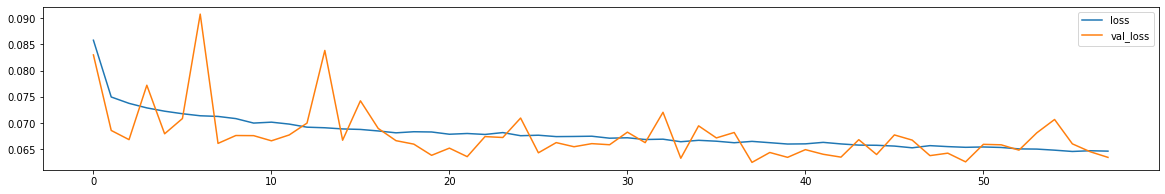

4
Train data size:  (9103, 1)
(9043, 30, 1) (9043, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
566/566 [==============================] - 5s 6ms/step - loss: 0.0808 - val_loss: 0.0996
Epoch 2/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0739 - val_loss: 0.0879
Epoch 3/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0718 - val_loss: 0.0944
Epoch 4/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0716 - val_loss: 0.0866
Epoch 5/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0715 - val_loss: 0.1009
Epoch 6/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0708 - val_loss: 0.0915
Epoch 7/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0703 - val_loss: 0.1012
Epoch 8/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0701 - val_loss: 0.0904
Epoch 9/70
566/566 [==============================] - 3s 5ms/step - loss: 0.0699 - val_loss: 0.0953
Epoch 10/70
566/566 [=

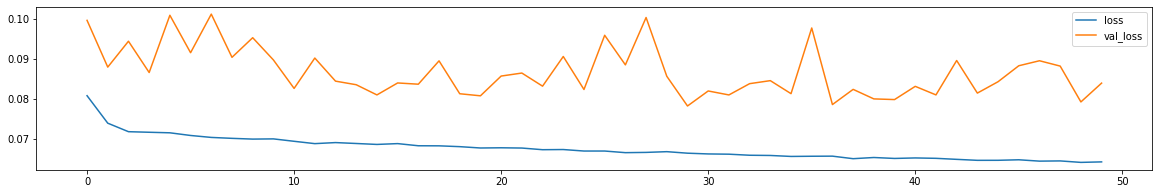

5
Train data size:  (10198, 1)
(10138, 30, 1) (10138, 1)
(1035, 30, 1) (1035, 1)
Epoch 1/70
634/634 [==============================] - 7s 7ms/step - loss: 0.0796 - val_loss: 0.0850
Epoch 2/70
634/634 [==============================] - 4s 6ms/step - loss: 0.0742 - val_loss: 0.0883
Epoch 3/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0733 - val_loss: 0.0851
Epoch 4/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0726 - val_loss: 0.0845
Epoch 5/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0716 - val_loss: 0.0807
Epoch 6/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0711 - val_loss: 0.0799
Epoch 7/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0707 - val_loss: 0.0772
Epoch 8/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0704 - val_loss: 0.0778
Epoch 9/70
634/634 [==============================] - 3s 5ms/step - loss: 0.0700 - val_loss: 0.0784
Epoch 10/70
634/634

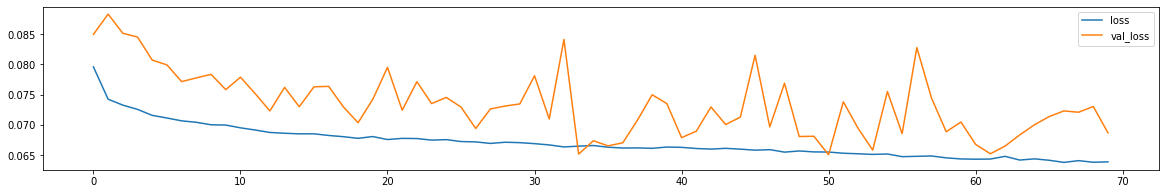

In [225]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

i = 1

n_seq = 1

X_orig = uni_df
y_orig = uni_df.BF10

cvscores = []

# iterating through the cross validation list
for train, test in list(ts_cv.split(X_orig, y_orig)):
    print(i) # <- FOLD number
    
    n_past = 30
    dataSize_train = len(y_orig.iloc[train])
    dataSize_test = len(y_orig.iloc[test])
    y_dat_train = y_orig.iloc[train].values.reshape(dataSize_train,1)
    y_dat_test = y_orig.iloc[test].values.reshape(dataSize_test,1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_y_dat_train = scaler.fit_transform(y_dat_train)
    scaled_y_dat_test = scaler.fit_transform(y_dat_test)
    
    print('Train data size: ', scaled_y_dat_train.shape)
    
    X_train,y_train = createDataset(scaled_y_dat_train, time_step=n_past)
    X_val,y_val = createDataset(scaled_y_dat_test, time_step=n_past)
    
    print(X_train.shape, y_train.shape)
    print(X_val.shape, y_val.shape)

    n_features = 1
    n_steps = 30

    X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
    X_val = X_val.reshape((X_val.shape[0], n_seq, n_steps, n_features))
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, strides=2, padding="valid", activation='relu'), 
                              input_shape=(None, n_steps, n_features)))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32, activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='rmsprop')
    history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=70, batch_size=16,verbose=1, callbacks=[callback], workers=4)

    #model_name = './drive/MyDrive/Models/CNN_lstm_' + str(i)
    #model.save(model_name)
    
    y_val_hat = scaler.inverse_transform(history.model.predict(X_val))
    y_val_original = scaler.inverse_transform(y_val)
    
    # adding the error metric
    rmse = sqrt(mean_squared_error(y_val_original, y_val_hat))
    print(rmse)
    
    #fold_max_val_loss = max(history.history['val_loss'])

    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    cvscores.append(rmse)
    
    i+=1

In [226]:
print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))

29.84 (+/- 1.24)


### Model comparison

After the conclusion of the modelling phase it is time to compare the results. All the models were able to beat the baseline, so we can declare that it is worthwhile to put more resources to develop more sophisticated ways for soil moisture forecasting. However, we could also see the limitations of these models. Linear Regression and Prophet did well, but they are prone to overfitting so their prediction might not be as accurate as the error metric suggests. The other models showed their limitations when it came to non-stationary data and in the future it would definitely be worthwhile to detrend the dataset and feed it to the models to check if their performance improves.

In the end the CNN model was chosen to make the final prediction of the BF10 value, because this model did generally well and showed less variance and overfitting than the other models.

In [228]:
results_df = pd.DataFrame([["Baseline Model","37.12"],
                    ["Linear Regression","26.94"],
                    ["Prophet", "27.44"],
                    ["Random Forest Regression", "37.03"],
                    ["ARIMA","36.80"],
                    ["Vanilla LSTM", "30.49"],
                    ["Stacked LSTM", "29.84"],
                    ["Bidirectional LSTM", "30.65"],
                    ["CNN LSTM", "29.84"]], 
                  columns=["Model name", "RMSE score"])

In [229]:
results_df

Model name RMSE score
0            Baseline Model      37.12
1         Linear Regression      26.94
2                   Prophet      27.44
3  Random Forest Regression      37.03
4                     ARIMA      36.80
5              Vanilla LSTM      30.49
6              Stacked LSTM      29.84
7        Bidirectional LSTM      30.65
8                  CNN LSTM      29.84

## Prediction

In [230]:
model_cnn_history = history

In [231]:
dataSize_test = len(y_orig[-1065:])
y_dat_test = y_orig[-1065:].values.reshape(dataSize_test,1)


scaler = MinMaxScaler(feature_range=(0,1))
scaled_y_dat_test = scaler.fit_transform(y_dat_test)

x_val = []
for i in range(len(scaled_y_dat_test) - 30):
    x_val.append(scaled_y_dat_test[i+1:(i+ 1 + 30)])
    
x_val = np.array(x_val)
x_val = x_val.reshape((x_val.shape[0], n_seq, n_steps, n_features))


print(x_val.shape)


y_val_hat = scaler.inverse_transform(model_cnn_history.model.predict(x_val))[1034]
print("PREDICT:")
print(y_val_hat)

(1035, 1, 30, 1)
33/33 [==============================] - 0s 3ms/step
PREDICT:
[82.83479]


Our prediction for 30.01.2022 is **82.83** BF10. Although the dataset does not contain a value for the specific date of our forecast, it is likely that the prediction is slightly smaller than the actual measurement, as the target variable is rarely lower than 100 in January.

## Conclusion

At the beginning we set our goal to predict the BF10 value for 30.01.2022. This has been achieved in the last cell of our code. Now it is time to reflect on the project and highlight what we have learned. We have managed to build several working machine learning models, all of which were able to beat the baseline metric. These models used only the time component to forecast BF10 values 30 days ahead. The convolutional neural network model proved to be the best fit to make the final prediction, after significant hyperparameter optimization. 

However, during the modelling process it has become very clear that these models have their limitations. In the future they could be further optimized in three ways.

First, the current models' hyperparameters could be further enhanced. The trial and error method we used could be very effect to get the best out of the machine learning algorithm, but it is very time consuming. There are automatized solutions to find the best parameters, for example Grid Search, Randomized Search and Ensemble methods just to name the most populare. Enhancing the hyperparameters would be the least resource-heavy approach to improve the forecast.

The second option is to further optimize the data pipeline of our algorithms. Some of the models struggled with the trend and seasonality in the time series, they would certainly perform better after some differencing. We could experiment also with other normalization techniques and transform the dataset to be more machine learning friendly.

Thirdly, we could introduce the other variables to the modelling. We could use correlation matrices to see which variable has a strong influence on our target variable. Multivariate time series algorithms could enhance the predictive power of our machine learning models.